### Creating Split Directories

Creates directory structure for data splitting into train, validation, and test sets.

In [1]:
import os
from pathlib import Path
import shutil

def create_split_directories(base_dir, classes):
    # Remove existing directories if they exist
    if os.path.exists(base_dir):
        shutil.rmtree(base_dir)
    
    # Create new directories
    for split in ['train', 'validation', 'test']:
        for class_name in classes:
            os.makedirs(Path(base_dir) / split / class_name, exist_ok=True)

# Global definitions
base_dir = 'data'
classes = ['Clams', 'Corals', 'Crabs', 'Dolphin', 'Eel', 'Fish', 'Jelly Fish', 'Lobster',
           'Nudibranchs', 'Octopus', 'Otter', 'Penguin', 'Puffers', 'Sea Rays', 'Sea Urchins',
           'Seahorse', 'Seal', 'Sharks', 'Shrimp', 'Squid', 'Starfish', 'Turtle_Tortoise', 'Whale']

# Create the necessary directories
create_split_directories(base_dir, classes)



### Spliting the dataset

 Splits the dataset into train, validation, and test sets and copies images accordingly to the folders.


In [2]:
import random
import shutil
from pathlib import Path

def split_dataset(source_dir, base_dir, classes, train_ratio=0.7, validation_ratio=0.15):
    for class_name in classes:
        class_dir = Path(source_dir) / class_name
        images = list(class_dir.glob('*.*'))
        random.shuffle(images)

        train_idx = int(len(images) * train_ratio)
        validation_idx = train_idx + int(len(images) * validation_ratio)

        train_images = images[:train_idx]
        validation_images = images[train_idx:validation_idx]
        test_images = images[validation_idx:]

        for image in train_images:
            shutil.copy(str(image), Path(base_dir) / 'train' / class_name / image.name)
        for image in validation_images:
            shutil.copy(str(image), Path(base_dir) / 'validation' / class_name / image.name)
        for image in test_images:
            shutil.copy(str(image), Path(base_dir) / 'test' / class_name / image.name)

# Define the source directory path containing the class folders with images
source_dir = 'sea_animals'

# Split the dataset into train, validation, and test sets
split_dataset(source_dir, base_dir, classes)

print("Dataset split into train, validation, and test sets successfully.")


Dataset split into train, validation, and test sets successfully.


### Ploting the data distribution

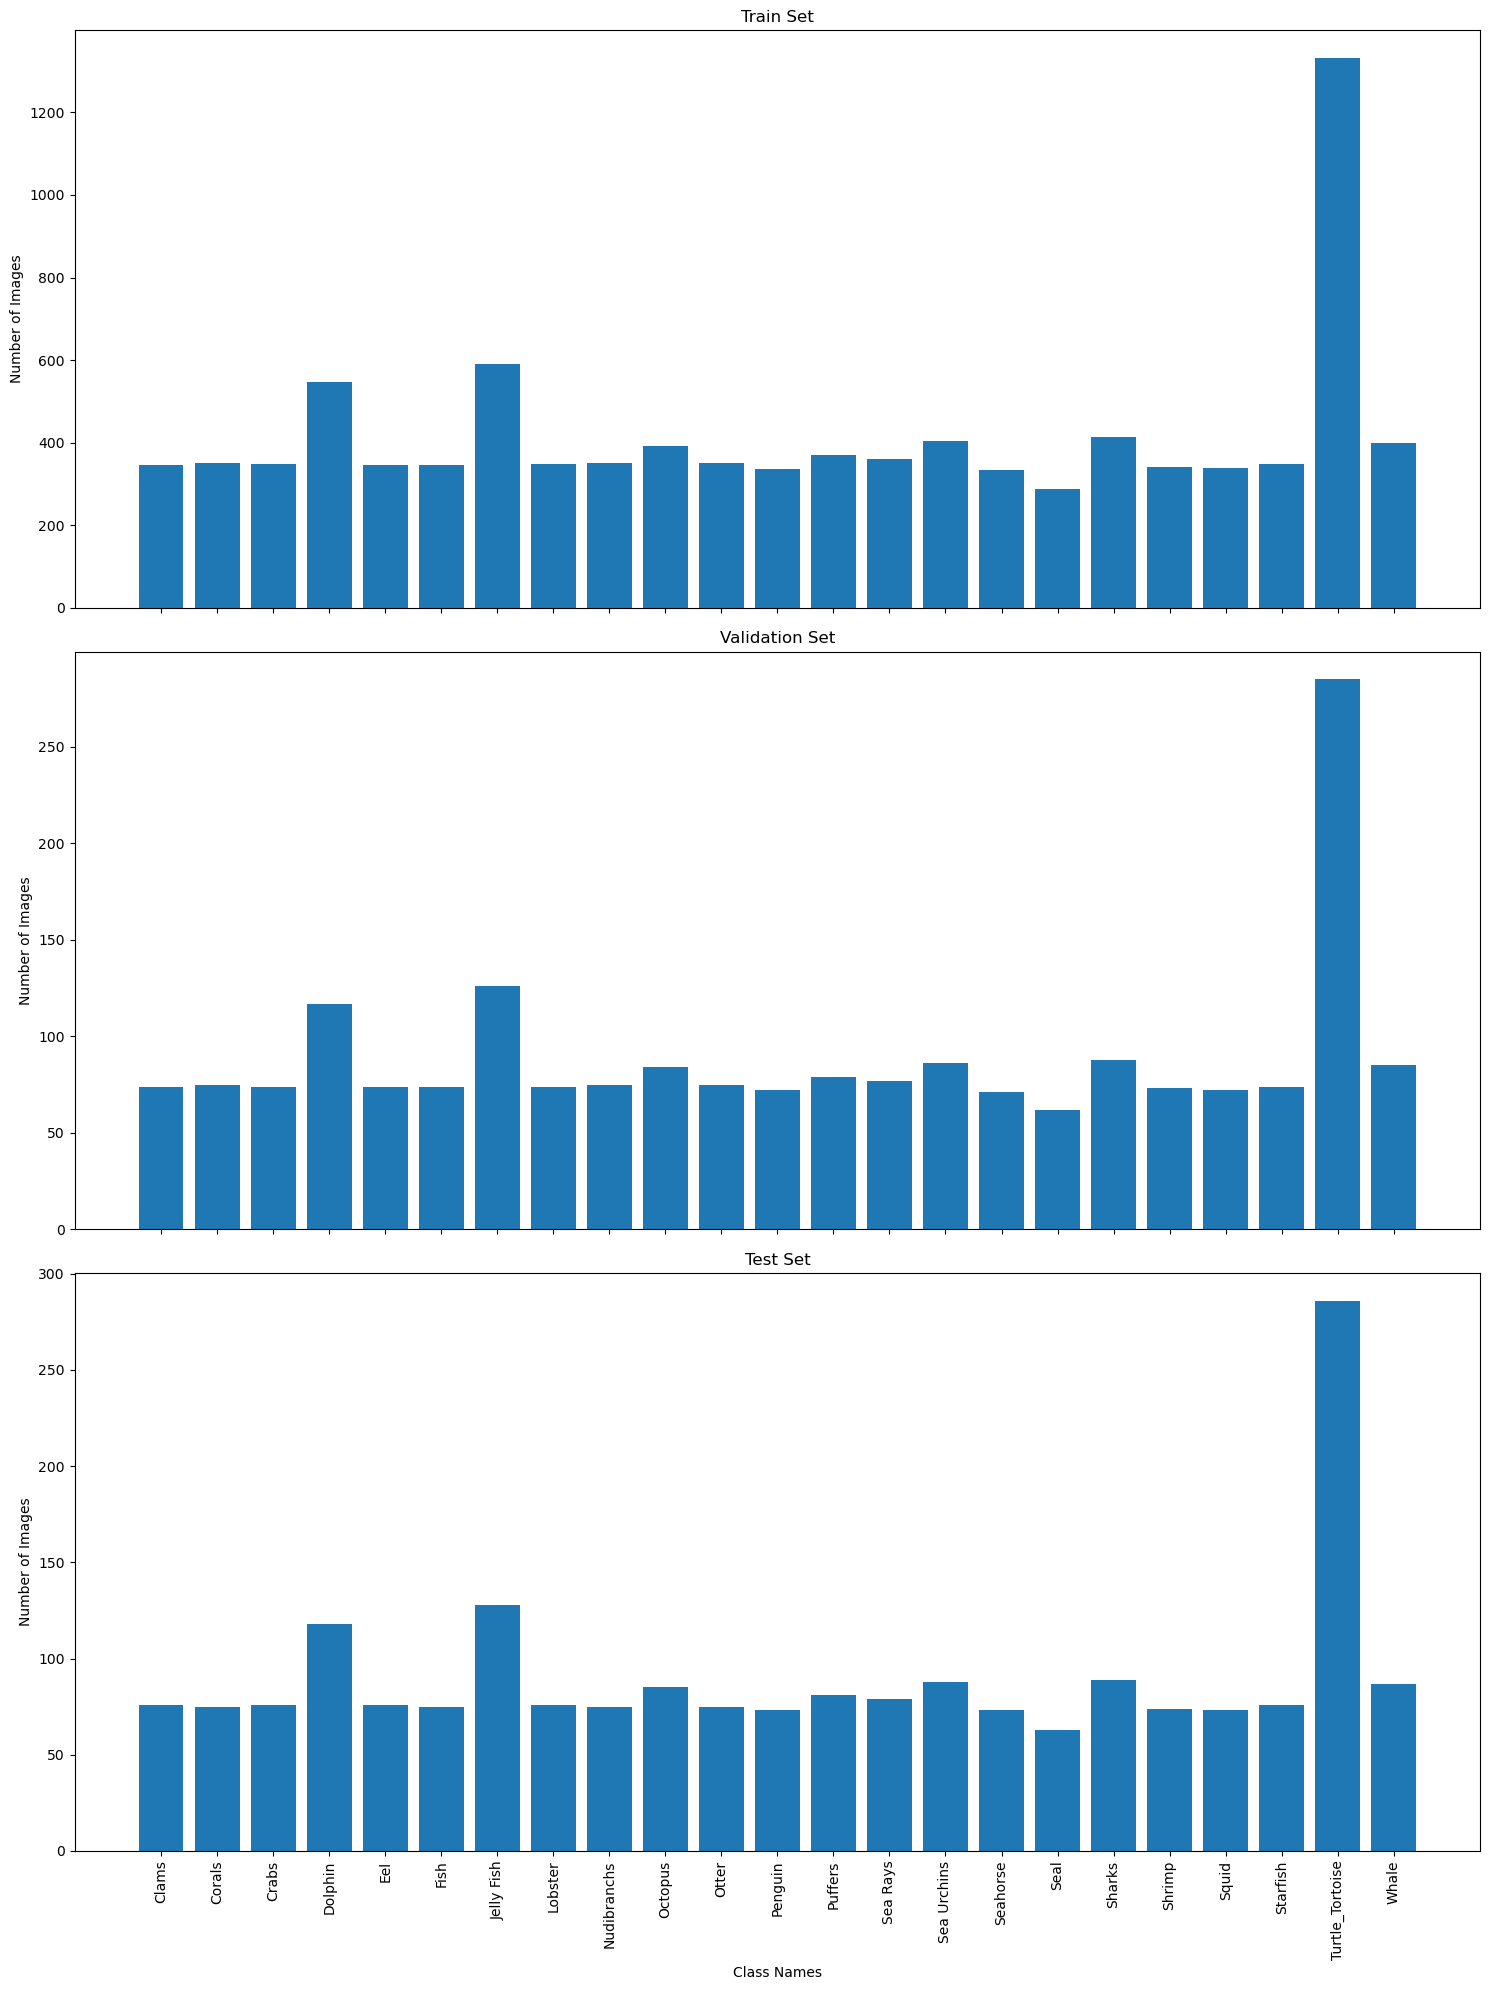

In [3]:
import os
import matplotlib.pyplot as plt

def plot_data_distribution(base_dir, classes):
    splits = ['train', 'validation', 'test']
    data_counts = {split: [] for split in splits}
    
    for split in splits:
        for class_name in classes:
            class_dir = os.path.join(base_dir, split, class_name)
            num_images = len(os.listdir(class_dir))
            data_counts[split].append(num_images)
    
    fig, ax = plt.subplots(3, 1, figsize=(15, 20), sharex=True)
    for idx, split in enumerate(splits):
        ax[idx].bar(classes, data_counts[split])
        ax[idx].set_title(f'{split.capitalize()} Set')
        ax[idx].set_ylabel('Number of Images')
        ax[idx].tick_params(axis='x', rotation=90)
    
    plt.xlabel('Class Names')
    plt.tight_layout()
    plt.show()

# Plot data distribution
plot_data_distribution(base_dir, classes)


### Balancing the dataset
#Balances the dataset by randomly removing excess images from each class directory.


In [4]:
import os
import random
from pathlib import Path

def balance_dataset(base_dir, classes, target_num_images):
    for class_name in classes:
        class_dir = Path(base_dir) / class_name
        images = list(class_dir.glob('*.*'))
        
        if len(images) > target_num_images:
            images_to_keep = random.sample(images, target_num_images)
            images_to_remove = set(images) - set(images_to_keep)
            
            for image in images_to_remove:
                os.remove(image)
            print(f'Removed {len(images_to_remove)} images from {class_name} in {base_dir}')

# Define the base directory paths for train, validation, and test sets
base_dirs = {
    'train': 'data/train',
    'validation': 'data/validation',
    'test': 'data/test'
}

# Target number of images for each dataset
target_num_images = {
    'train': 600,
    'validation': 200,
    'test': 200
}

# Balance the dataset for the training, validation, and test sets
for split, base_dir in base_dirs.items():
    balance_dataset(base_dir, classes, target_num_images[split])


Removed 732 images from Turtle_Tortoise in data/train
Removed 85 images from Turtle_Tortoise in data/validation
Removed 86 images from Turtle_Tortoise in data/test


### Plot random images from training dataset

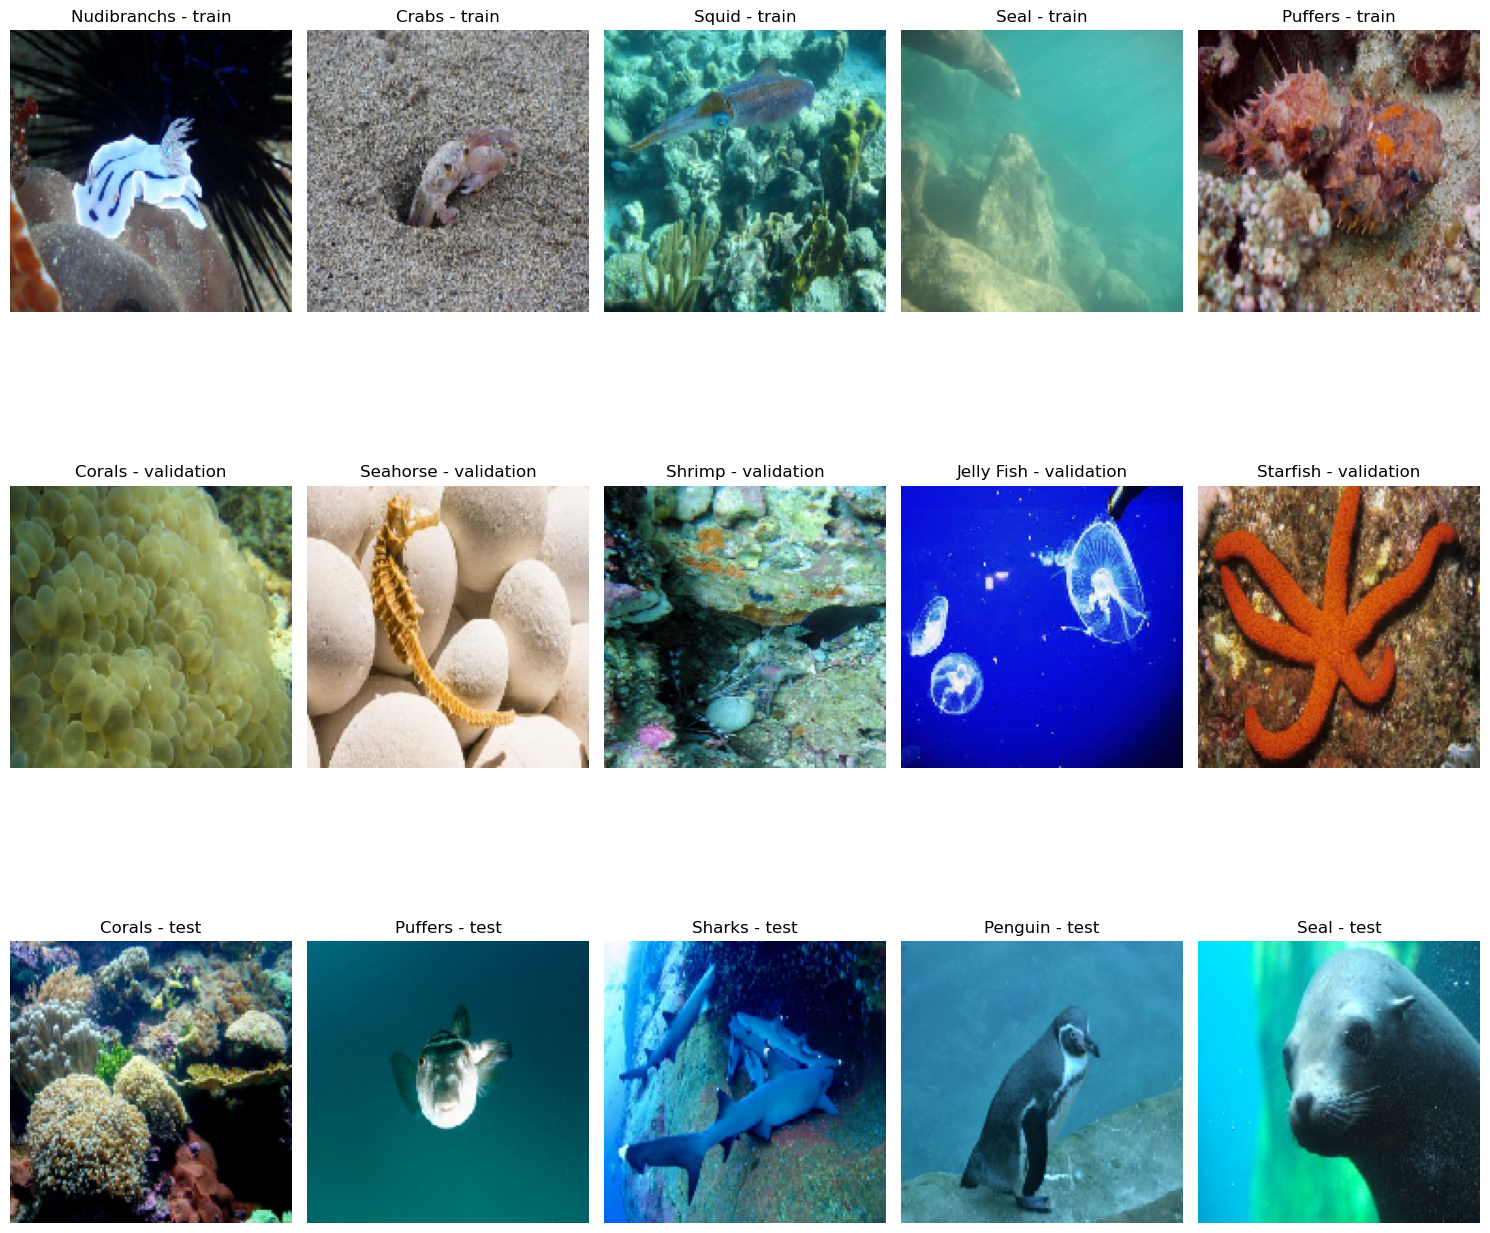

In [5]:
import random
from pathlib import Path
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def plot_random_images(base_dir, classes, num_images=5):
    splits = ['train', 'validation', 'test']
    fig, axes = plt.subplots(len(splits), num_images, figsize=(15, 15))

    for i, split in enumerate(splits):
        for j in range(num_images):
            class_name = random.choice(classes)
            class_dir = Path(base_dir) / split / class_name
            image_file = random.choice(os.listdir(class_dir))
            img_path = class_dir / image_file

            img = load_img(img_path, target_size=(150, 150))
            img_array = img_to_array(img) / 255.0

            ax = axes[i, j]
            ax.imshow(img_array)
            ax.axis('off')
            ax.set_title(f'{class_name} - {split}')

    plt.tight_layout()
    plt.show()
    
base_dir = 'data'
# Plot random images
plot_random_images(base_dir, classes)


### Creating Image Data Generators
#Creates and configures ImageDataGenerators for training and validation sets.


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def create_data_generators():
    # Configure data augmentation for training data
    train_datagen = ImageDataGenerator(
        rescale=1./255, rotation_range=40, width_shift_range=0.2, height_shift_range=0.2,
        shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest'
    )
    
    # Rescale validation data
    val_datagen = ImageDataGenerator(rescale=1./255)
        
    # Create generator for training data

    train_generator = train_datagen.flow_from_directory(
        'data/train', target_size=(150, 150), batch_size=32, class_mode='categorical'
    )
    validation_generator = val_datagen.flow_from_directory(
        'data/validation', target_size=(150, 150), batch_size=32, class_mode='categorical'
    )
    return train_generator, validation_generator

# Create image data generators
train_generator, validation_generator = create_data_generators()


Found 8856 images belonging to 23 classes.
Found 1961 images belonging to 23 classes.


### Setting up the dataloaders for LeNet, AlexNet, VGG16

In [7]:
import os
from torchvision import datasets, transforms
import torch

def setup_data_loaders(base_dir, classes):
    
    # Define data transformations for LeNet

    data_transforms_lenet = {
        'train': transforms.Compose([
            transforms.Resize((32, 32)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ]),
        'validation': transforms.Compose([
            transforms.Resize((32, 32)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ]),
    }
    # Define data transformations for AlexNet and VGG16

    data_transforms_alexnet_vgg16 = {
        'train': transforms.Compose([
            transforms.Resize(256),  # Resize to 256 to allow center crop
            transforms.RandomResizedCrop(224),  # Resize to 224x224 for AlexNet/VGG16
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'validation': transforms.Compose([
            transforms.Resize(256),  # Resize to 256 to allow center crop
            transforms.CenterCrop(224),  # Resize to 224x224 for AlexNet/VGG16
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }

    # Create datasets and dataloaders for LeNet

    image_datasets_lenet = {x: datasets.ImageFolder(os.path.join(base_dir, x), data_transforms_lenet[x]) for x in ['train', 'validation']}
    dataloaders_lenet = {x: torch.utils.data.DataLoader(image_datasets_lenet[x], batch_size=32, shuffle=True, num_workers=4) for x in ['train', 'validation']}
    dataset_sizes_lenet = {x: len(image_datasets_lenet[x]) for x in ['train', 'validation']}

    # Create datasets and dataloaders for AlexNet and VGG16
    image_datasets_alexnet_vgg16 = {x: datasets.ImageFolder(os.path.join(base_dir, x), data_transforms_alexnet_vgg16[x]) for x in ['train', 'validation']}
    dataloaders_alexnet_vgg16 = {x: torch.utils.data.DataLoader(image_datasets_alexnet_vgg16[x], batch_size=32, shuffle=True, num_workers=4) for x in ['train', 'validation']}
    dataset_sizes_alexnet_vgg16 = {x: len(image_datasets_alexnet_vgg16[x]) for x in ['train', 'validation']}
    # Get class names    
    class_names = image_datasets_lenet['train'].classes
    
    return dataloaders_lenet, dataset_sizes_lenet, dataloaders_alexnet_vgg16, dataset_sizes_alexnet_vgg16, class_names

# Setup data loaders
base_dir = 'data'
classes = ['Clams', 'Corals', 'Crabs', 'Dolphin', 'Eel', 'Fish', 'Jelly Fish', 'Lobster',
           'Nudibranchs', 'Octopus', 'Otter', 'Penguin', 'Puffers', 'Sea Rays', 'Sea Urchins',
           'Seahorse', 'Seal', 'Sharks', 'Shrimp', 'Squid', 'Starfish', 'Turtle_Tortoise', 'Whale']

dataloaders_lenet, dataset_sizes_lenet, dataloaders_alexnet_vgg16, dataset_sizes_alexnet_vgg16, class_names = setup_data_loaders(base_dir, classes)


### Training function

In [8]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
from tqdm import tqdm

def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs=10, device='cpu'):
    since = time.time()
    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'validation']:
            model.train() if phase == 'train' else model.eval()

            running_loss = 0.0
            running_corrects = 0

            data_loader = tqdm(dataloaders[phase], desc='Epoch {} {}'.format(epoch+1, phase))

            for inputs, labels in data_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    torch.save(best_model_wts, 'best_model.pth')
    model.load_state_dict(best_model_wts)
    return model


## Structure of The Models and its Training Validation 

## LeNet

In [9]:
import torch.nn.functional as F

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 23)  # Adjust output layer for 23 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [151]:
# Setup device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize the model
model = LeNet().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Number of epochs for training
num_epochs = 100

# Train the model
#model = train_model(model, criterion, optimizer, scheduler, dataloaders_lenet, dataset_sizes_lenet, num_epochs=num_epochs, device=device)
# Save the trained model
#torch.save(model.state_dict(), 'lenet_model.pth')
#print("LeNet model saved to 'lenet_model.pth'")

Epoch 0/99
----------


Epoch 1 train: 100%|██████████| 277/277 [00:39<00:00,  7.08it/s]


train Loss: 3.1308 Acc: 0.0673


Epoch 1 validation: 100%|██████████| 62/62 [00:37<00:00,  1.66it/s]


validation Loss: 3.1237 Acc: 0.0643

Epoch 1/99
----------


Epoch 2 train: 100%|██████████| 277/277 [00:41<00:00,  6.72it/s]


train Loss: 3.1228 Acc: 0.0667


Epoch 2 validation: 100%|██████████| 62/62 [00:37<00:00,  1.67it/s]


validation Loss: 3.1109 Acc: 0.0643

Epoch 2/99
----------


Epoch 3 train: 100%|██████████| 277/277 [00:39<00:00,  6.99it/s]


train Loss: 3.1119 Acc: 0.0813


Epoch 3 validation: 100%|██████████| 62/62 [00:40<00:00,  1.52it/s]


validation Loss: 3.0897 Acc: 0.1341

Epoch 3/99
----------


Epoch 4 train: 100%|██████████| 277/277 [00:43<00:00,  6.41it/s]


train Loss: 3.0787 Acc: 0.1116


Epoch 4 validation: 100%|██████████| 62/62 [01:15<00:00,  1.21s/it] 


validation Loss: 3.0112 Acc: 0.1428

Epoch 4/99
----------


Epoch 5 train: 100%|██████████| 277/277 [37:03<00:00,  8.03s/it]    


train Loss: 2.9187 Acc: 0.1203


Epoch 5 validation: 100%|██████████| 62/62 [00:48<00:00,  1.28it/s]


validation Loss: 2.7873 Acc: 0.1652

Epoch 5/99
----------


Epoch 6 train: 100%|██████████| 277/277 [00:39<00:00,  7.01it/s]


train Loss: 2.7682 Acc: 0.1451


Epoch 6 validation: 100%|██████████| 62/62 [00:35<00:00,  1.76it/s]


validation Loss: 2.7189 Acc: 0.1678

Epoch 6/99
----------


Epoch 7 train: 100%|██████████| 277/277 [00:38<00:00,  7.14it/s]


train Loss: 2.7024 Acc: 0.1660


Epoch 7 validation: 100%|██████████| 62/62 [00:35<00:00,  1.74it/s]


validation Loss: 2.6567 Acc: 0.1846

Epoch 7/99
----------


Epoch 8 train: 100%|██████████| 277/277 [00:39<00:00,  6.97it/s]


train Loss: 2.6448 Acc: 0.1815


Epoch 8 validation: 100%|██████████| 62/62 [00:35<00:00,  1.76it/s]


validation Loss: 2.6403 Acc: 0.2075

Epoch 8/99
----------


Epoch 9 train: 100%|██████████| 277/277 [00:39<00:00,  7.08it/s]


train Loss: 2.6347 Acc: 0.1905


Epoch 9 validation: 100%|██████████| 62/62 [00:35<00:00,  1.74it/s]


validation Loss: 2.6347 Acc: 0.2055

Epoch 9/99
----------


Epoch 10 train: 100%|██████████| 277/277 [00:39<00:00,  7.04it/s]


train Loss: 2.6292 Acc: 0.1921


Epoch 10 validation: 100%|██████████| 62/62 [00:36<00:00,  1.68it/s]


validation Loss: 2.6268 Acc: 0.2075

Epoch 10/99
----------


Epoch 11 train: 100%|██████████| 277/277 [00:40<00:00,  6.78it/s]


train Loss: 2.6238 Acc: 0.1932


Epoch 11 validation: 100%|██████████| 62/62 [00:37<00:00,  1.67it/s]


validation Loss: 2.6223 Acc: 0.2045

Epoch 11/99
----------


Epoch 12 train: 100%|██████████| 277/277 [00:40<00:00,  6.88it/s]


train Loss: 2.6181 Acc: 0.1998


Epoch 12 validation: 100%|██████████| 62/62 [00:36<00:00,  1.71it/s]


validation Loss: 2.6184 Acc: 0.2055

Epoch 12/99
----------


Epoch 13 train: 100%|██████████| 277/277 [00:38<00:00,  7.14it/s]


train Loss: 2.6136 Acc: 0.1985


Epoch 13 validation: 100%|██████████| 62/62 [00:37<00:00,  1.64it/s]


validation Loss: 2.6172 Acc: 0.2086

Epoch 13/99
----------


Epoch 14 train: 100%|██████████| 277/277 [00:39<00:00,  6.95it/s]


train Loss: 2.6090 Acc: 0.1985


Epoch 14 validation: 100%|██████████| 62/62 [00:36<00:00,  1.69it/s]


validation Loss: 2.6151 Acc: 0.2086

Epoch 14/99
----------


Epoch 15 train: 100%|██████████| 277/277 [00:39<00:00,  7.01it/s]


train Loss: 2.6023 Acc: 0.2019


Epoch 15 validation: 100%|██████████| 62/62 [00:35<00:00,  1.73it/s]


validation Loss: 2.6115 Acc: 0.2096

Epoch 15/99
----------


Epoch 16 train: 100%|██████████| 277/277 [00:39<00:00,  7.10it/s]


train Loss: 2.6017 Acc: 0.2025


Epoch 16 validation: 100%|██████████| 62/62 [00:35<00:00,  1.73it/s]


validation Loss: 2.6099 Acc: 0.2111

Epoch 16/99
----------


Epoch 17 train: 100%|██████████| 277/277 [00:39<00:00,  6.98it/s]


train Loss: 2.6003 Acc: 0.2022


Epoch 17 validation: 100%|██████████| 62/62 [00:37<00:00,  1.67it/s]


validation Loss: 2.6091 Acc: 0.2091

Epoch 17/99
----------


Epoch 18 train: 100%|██████████| 277/277 [00:40<00:00,  6.90it/s]


train Loss: 2.6009 Acc: 0.2034


Epoch 18 validation: 100%|██████████| 62/62 [00:36<00:00,  1.69it/s]


validation Loss: 2.6083 Acc: 0.2096

Epoch 18/99
----------


Epoch 19 train: 100%|██████████| 277/277 [00:39<00:00,  6.93it/s]


train Loss: 2.5997 Acc: 0.2049


Epoch 19 validation: 100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


validation Loss: 2.6080 Acc: 0.2101

Epoch 19/99
----------


Epoch 20 train: 100%|██████████| 277/277 [00:41<00:00,  6.73it/s]


train Loss: 2.6007 Acc: 0.2017


Epoch 20 validation: 100%|██████████| 62/62 [00:37<00:00,  1.67it/s]


validation Loss: 2.6075 Acc: 0.2132

Epoch 20/99
----------


Epoch 21 train: 100%|██████████| 277/277 [00:39<00:00,  6.97it/s]


train Loss: 2.5987 Acc: 0.2034


Epoch 21 validation: 100%|██████████| 62/62 [00:36<00:00,  1.71it/s]


validation Loss: 2.6071 Acc: 0.2132

Epoch 21/99
----------


Epoch 22 train: 100%|██████████| 277/277 [00:39<00:00,  6.96it/s]


train Loss: 2.5978 Acc: 0.2047


Epoch 22 validation: 100%|██████████| 62/62 [00:36<00:00,  1.70it/s]


validation Loss: 2.6071 Acc: 0.2121

Epoch 22/99
----------


Epoch 23 train: 100%|██████████| 277/277 [00:39<00:00,  6.94it/s]


train Loss: 2.5985 Acc: 0.2055


Epoch 23 validation: 100%|██████████| 62/62 [00:36<00:00,  1.72it/s]


validation Loss: 2.6070 Acc: 0.2121

Epoch 23/99
----------


Epoch 24 train: 100%|██████████| 277/277 [00:39<00:00,  7.06it/s]


train Loss: 2.5985 Acc: 0.2060


Epoch 24 validation: 100%|██████████| 62/62 [00:36<00:00,  1.72it/s]


validation Loss: 2.6070 Acc: 0.2116

Epoch 24/99
----------


Epoch 25 train: 100%|██████████| 277/277 [00:39<00:00,  7.05it/s]


train Loss: 2.5983 Acc: 0.2033


Epoch 25 validation: 100%|██████████| 62/62 [00:35<00:00,  1.74it/s]


validation Loss: 2.6070 Acc: 0.2121

Epoch 25/99
----------


Epoch 26 train: 100%|██████████| 277/277 [00:39<00:00,  7.09it/s]


train Loss: 2.5984 Acc: 0.2037


Epoch 26 validation: 100%|██████████| 62/62 [00:35<00:00,  1.73it/s]


validation Loss: 2.6069 Acc: 0.2121

Epoch 26/99
----------


Epoch 27 train: 100%|██████████| 277/277 [00:38<00:00,  7.10it/s]


train Loss: 2.5985 Acc: 0.2040


Epoch 27 validation: 100%|██████████| 62/62 [00:36<00:00,  1.72it/s]


validation Loss: 2.6069 Acc: 0.2121

Epoch 27/99
----------


Epoch 28 train: 100%|██████████| 277/277 [00:39<00:00,  6.95it/s]


train Loss: 2.5977 Acc: 0.2035


Epoch 28 validation: 100%|██████████| 62/62 [00:35<00:00,  1.75it/s]


validation Loss: 2.6068 Acc: 0.2111

Epoch 28/99
----------


Epoch 29 train: 100%|██████████| 277/277 [00:39<00:00,  7.01it/s]


train Loss: 2.5981 Acc: 0.2040


Epoch 29 validation: 100%|██████████| 62/62 [00:35<00:00,  1.73it/s]


validation Loss: 2.6068 Acc: 0.2116

Epoch 29/99
----------


Epoch 30 train: 100%|██████████| 277/277 [00:39<00:00,  6.93it/s]


train Loss: 2.5984 Acc: 0.2036


Epoch 30 validation: 100%|██████████| 62/62 [00:35<00:00,  1.73it/s]


validation Loss: 2.6068 Acc: 0.2111

Epoch 30/99
----------


Epoch 31 train: 100%|██████████| 277/277 [00:39<00:00,  7.08it/s]


train Loss: 2.5983 Acc: 0.2073


Epoch 31 validation: 100%|██████████| 62/62 [00:35<00:00,  1.72it/s]


validation Loss: 2.6068 Acc: 0.2116

Epoch 31/99
----------


Epoch 32 train: 100%|██████████| 277/277 [00:39<00:00,  7.08it/s]


train Loss: 2.5984 Acc: 0.2046


Epoch 32 validation: 100%|██████████| 62/62 [00:36<00:00,  1.71it/s]


validation Loss: 2.6068 Acc: 0.2116

Epoch 32/99
----------


Epoch 33 train: 100%|██████████| 277/277 [00:40<00:00,  6.89it/s]


train Loss: 2.5973 Acc: 0.2051


Epoch 33 validation: 100%|██████████| 62/62 [00:36<00:00,  1.72it/s]


validation Loss: 2.6068 Acc: 0.2116

Epoch 33/99
----------


Epoch 34 train: 100%|██████████| 277/277 [00:39<00:00,  7.01it/s]


train Loss: 2.5989 Acc: 0.2051


Epoch 34 validation: 100%|██████████| 62/62 [00:35<00:00,  1.74it/s]


validation Loss: 2.6068 Acc: 0.2116

Epoch 34/99
----------


Epoch 35 train: 100%|██████████| 277/277 [00:40<00:00,  6.92it/s]


train Loss: 2.5981 Acc: 0.2029


Epoch 35 validation: 100%|██████████| 62/62 [00:36<00:00,  1.68it/s]


validation Loss: 2.6068 Acc: 0.2116

Epoch 35/99
----------


Epoch 36 train: 100%|██████████| 277/277 [00:39<00:00,  7.05it/s]


train Loss: 2.5988 Acc: 0.2064


Epoch 36 validation: 100%|██████████| 62/62 [00:36<00:00,  1.70it/s]


validation Loss: 2.6068 Acc: 0.2116

Epoch 36/99
----------


Epoch 37 train: 100%|██████████| 277/277 [00:39<00:00,  6.93it/s]


train Loss: 2.5976 Acc: 0.2047


Epoch 37 validation: 100%|██████████| 62/62 [00:35<00:00,  1.72it/s]


validation Loss: 2.6068 Acc: 0.2116

Epoch 37/99
----------


Epoch 38 train: 100%|██████████| 277/277 [00:39<00:00,  7.08it/s]


train Loss: 2.5972 Acc: 0.2047


Epoch 38 validation: 100%|██████████| 62/62 [00:36<00:00,  1.72it/s]


validation Loss: 2.6068 Acc: 0.2116

Epoch 38/99
----------


Epoch 39 train: 100%|██████████| 277/277 [00:39<00:00,  7.09it/s]


train Loss: 2.5983 Acc: 0.2057


Epoch 39 validation: 100%|██████████| 62/62 [00:36<00:00,  1.72it/s]


validation Loss: 2.6068 Acc: 0.2116

Epoch 39/99
----------


Epoch 40 train: 100%|██████████| 277/277 [00:39<00:00,  7.07it/s]


train Loss: 2.5979 Acc: 0.2053


Epoch 40 validation: 100%|██████████| 62/62 [00:37<00:00,  1.68it/s]


validation Loss: 2.6068 Acc: 0.2116

Epoch 40/99
----------


Epoch 41 train: 100%|██████████| 277/277 [00:39<00:00,  6.97it/s]


train Loss: 2.5979 Acc: 0.2039


Epoch 41 validation: 100%|██████████| 62/62 [00:35<00:00,  1.75it/s]


validation Loss: 2.6068 Acc: 0.2116

Epoch 41/99
----------


Epoch 42 train: 100%|██████████| 277/277 [00:39<00:00,  7.05it/s]


train Loss: 2.5978 Acc: 0.2055


Epoch 42 validation: 100%|██████████| 62/62 [00:36<00:00,  1.72it/s]


validation Loss: 2.6068 Acc: 0.2116

Epoch 42/99
----------


Epoch 43 train: 100%|██████████| 277/277 [00:39<00:00,  7.08it/s]


train Loss: 2.5985 Acc: 0.2057


Epoch 43 validation: 100%|██████████| 62/62 [00:35<00:00,  1.74it/s]


validation Loss: 2.6068 Acc: 0.2116

Epoch 43/99
----------


Epoch 44 train: 100%|██████████| 277/277 [00:40<00:00,  6.84it/s]


train Loss: 2.5990 Acc: 0.2036


Epoch 44 validation: 100%|██████████| 62/62 [00:35<00:00,  1.73it/s]


validation Loss: 2.6068 Acc: 0.2116

Epoch 44/99
----------


Epoch 45 train: 100%|██████████| 277/277 [00:39<00:00,  7.09it/s]


train Loss: 2.5987 Acc: 0.2034


Epoch 45 validation: 100%|██████████| 62/62 [00:35<00:00,  1.73it/s]


validation Loss: 2.6068 Acc: 0.2116

Epoch 45/99
----------


Epoch 46 train: 100%|██████████| 277/277 [00:38<00:00,  7.21it/s]


train Loss: 2.5981 Acc: 0.2049


Epoch 46 validation: 100%|██████████| 62/62 [00:35<00:00,  1.74it/s]


validation Loss: 2.6068 Acc: 0.2116

Epoch 46/99
----------


Epoch 47 train: 100%|██████████| 277/277 [00:38<00:00,  7.12it/s]


train Loss: 2.5986 Acc: 0.2017


Epoch 47 validation: 100%|██████████| 62/62 [00:35<00:00,  1.74it/s]


validation Loss: 2.6068 Acc: 0.2116

Epoch 47/99
----------


Epoch 48 train: 100%|██████████| 277/277 [00:38<00:00,  7.13it/s]


train Loss: 2.5976 Acc: 0.2054


Epoch 48 validation: 100%|██████████| 62/62 [00:36<00:00,  1.72it/s]


validation Loss: 2.6068 Acc: 0.2116

Epoch 48/99
----------


Epoch 49 train: 100%|██████████| 277/277 [00:39<00:00,  7.02it/s]


train Loss: 2.5971 Acc: 0.2049


Epoch 49 validation: 100%|██████████| 62/62 [00:35<00:00,  1.73it/s]


validation Loss: 2.6068 Acc: 0.2116

Epoch 49/99
----------


Epoch 50 train: 100%|██████████| 277/277 [00:37<00:00,  7.39it/s]


train Loss: 2.5979 Acc: 0.2046


Epoch 50 validation: 100%|██████████| 62/62 [00:29<00:00,  2.11it/s]


validation Loss: 2.6068 Acc: 0.2116

Epoch 50/99
----------


Epoch 51 train: 100%|██████████| 277/277 [00:33<00:00,  8.21it/s]


train Loss: 2.5976 Acc: 0.2043


Epoch 51 validation: 100%|██████████| 62/62 [00:29<00:00,  2.10it/s]


validation Loss: 2.6068 Acc: 0.2116

Epoch 51/99
----------


Epoch 52 train: 100%|██████████| 277/277 [00:33<00:00,  8.24it/s]


train Loss: 2.5995 Acc: 0.2040


Epoch 52 validation: 100%|██████████| 62/62 [00:31<00:00,  2.00it/s]


validation Loss: 2.6068 Acc: 0.2116

Epoch 52/99
----------


Epoch 53 train: 100%|██████████| 277/277 [00:38<00:00,  7.25it/s]


train Loss: 2.5977 Acc: 0.2053


Epoch 53 validation: 100%|██████████| 62/62 [00:39<00:00,  1.58it/s]


validation Loss: 2.6068 Acc: 0.2116

Epoch 53/99
----------


Epoch 54 train: 100%|██████████| 277/277 [00:40<00:00,  6.80it/s]


train Loss: 2.5974 Acc: 0.2037


Epoch 54 validation: 100%|██████████| 62/62 [00:36<00:00,  1.70it/s]


validation Loss: 2.6068 Acc: 0.2116

Epoch 54/99
----------


Epoch 55 train: 100%|██████████| 277/277 [00:39<00:00,  6.97it/s]


train Loss: 2.5981 Acc: 0.2038


Epoch 55 validation: 100%|██████████| 62/62 [00:36<00:00,  1.71it/s]


validation Loss: 2.6068 Acc: 0.2116

Epoch 55/99
----------


Epoch 56 train: 100%|██████████| 277/277 [00:39<00:00,  7.01it/s]


train Loss: 2.5974 Acc: 0.2060


Epoch 56 validation: 100%|██████████| 62/62 [00:37<00:00,  1.66it/s]


validation Loss: 2.6068 Acc: 0.2116

Epoch 56/99
----------


Epoch 57 train: 100%|██████████| 277/277 [00:39<00:00,  6.94it/s]


train Loss: 2.5989 Acc: 0.2052


Epoch 57 validation: 100%|██████████| 62/62 [00:35<00:00,  1.73it/s]


validation Loss: 2.6068 Acc: 0.2116

Epoch 57/99
----------


Epoch 58 train: 100%|██████████| 277/277 [00:39<00:00,  7.01it/s]


train Loss: 2.5978 Acc: 0.2037


Epoch 58 validation: 100%|██████████| 62/62 [00:36<00:00,  1.70it/s]


validation Loss: 2.6068 Acc: 0.2116

Epoch 58/99
----------


Epoch 59 train: 100%|██████████| 277/277 [00:40<00:00,  6.89it/s]


train Loss: 2.5980 Acc: 0.2052


Epoch 59 validation: 100%|██████████| 62/62 [00:36<00:00,  1.72it/s]


validation Loss: 2.6068 Acc: 0.2116

Epoch 59/99
----------


Epoch 60 train: 100%|██████████| 277/277 [00:39<00:00,  7.02it/s]


train Loss: 2.5975 Acc: 0.2043


Epoch 60 validation: 100%|██████████| 62/62 [00:35<00:00,  1.72it/s]


validation Loss: 2.6068 Acc: 0.2116

Epoch 60/99
----------


Epoch 61 train: 100%|██████████| 277/277 [00:39<00:00,  6.98it/s]


train Loss: 2.5986 Acc: 0.2042


Epoch 61 validation: 100%|██████████| 62/62 [00:36<00:00,  1.71it/s]


validation Loss: 2.6068 Acc: 0.2116

Epoch 61/99
----------


Epoch 62 train: 100%|██████████| 277/277 [00:40<00:00,  6.89it/s]


train Loss: 2.5984 Acc: 0.2049


Epoch 62 validation: 100%|██████████| 62/62 [00:38<00:00,  1.61it/s]


validation Loss: 2.6068 Acc: 0.2116

Epoch 62/99
----------


Epoch 63 train: 100%|██████████| 277/277 [00:39<00:00,  6.98it/s]


train Loss: 2.5979 Acc: 0.2034


Epoch 63 validation: 100%|██████████| 62/62 [00:37<00:00,  1.67it/s]


validation Loss: 2.6068 Acc: 0.2116

Epoch 63/99
----------


Epoch 64 train: 100%|██████████| 277/277 [00:39<00:00,  7.04it/s]


train Loss: 2.5983 Acc: 0.2045


Epoch 64 validation: 100%|██████████| 62/62 [00:36<00:00,  1.70it/s]


validation Loss: 2.6068 Acc: 0.2116

Epoch 64/99
----------


Epoch 65 train: 100%|██████████| 277/277 [00:40<00:00,  6.85it/s]


train Loss: 2.5980 Acc: 0.2048


Epoch 65 validation: 100%|██████████| 62/62 [00:37<00:00,  1.66it/s]


validation Loss: 2.6068 Acc: 0.2116

Epoch 65/99
----------


Epoch 66 train: 100%|██████████| 277/277 [00:39<00:00,  6.99it/s]


train Loss: 2.5979 Acc: 0.2051


Epoch 66 validation: 100%|██████████| 62/62 [00:36<00:00,  1.70it/s]


validation Loss: 2.6068 Acc: 0.2116

Epoch 66/99
----------


Epoch 67 train: 100%|██████████| 277/277 [00:41<00:00,  6.65it/s]


train Loss: 2.5981 Acc: 0.2051


Epoch 67 validation: 100%|██████████| 62/62 [00:36<00:00,  1.70it/s]


validation Loss: 2.6068 Acc: 0.2116

Epoch 67/99
----------


Epoch 68 train: 100%|██████████| 277/277 [00:39<00:00,  7.02it/s]


train Loss: 2.5982 Acc: 0.2044


Epoch 68 validation: 100%|██████████| 62/62 [00:36<00:00,  1.72it/s]


validation Loss: 2.6068 Acc: 0.2116

Epoch 68/99
----------


Epoch 69 train: 100%|██████████| 277/277 [00:38<00:00,  7.11it/s]


train Loss: 2.5978 Acc: 0.2055


Epoch 69 validation: 100%|██████████| 62/62 [00:36<00:00,  1.72it/s]


validation Loss: 2.6068 Acc: 0.2116

Epoch 69/99
----------


Epoch 70 train: 100%|██████████| 277/277 [00:38<00:00,  7.12it/s]


train Loss: 2.5977 Acc: 0.2035


Epoch 70 validation: 100%|██████████| 62/62 [00:35<00:00,  1.75it/s]


validation Loss: 2.6068 Acc: 0.2116

Epoch 70/99
----------


Epoch 71 train: 100%|██████████| 277/277 [00:39<00:00,  7.09it/s]


train Loss: 2.5982 Acc: 0.2046


Epoch 71 validation: 100%|██████████| 62/62 [00:35<00:00,  1.75it/s]


validation Loss: 2.6068 Acc: 0.2116

Epoch 71/99
----------


Epoch 72 train: 100%|██████████| 277/277 [00:38<00:00,  7.22it/s]


train Loss: 2.5972 Acc: 0.2040


Epoch 72 validation: 100%|██████████| 62/62 [00:35<00:00,  1.75it/s]


validation Loss: 2.6068 Acc: 0.2116

Epoch 72/99
----------


Epoch 73 train: 100%|██████████| 277/277 [00:39<00:00,  7.10it/s]


train Loss: 2.5975 Acc: 0.2036


Epoch 73 validation: 100%|██████████| 62/62 [00:35<00:00,  1.75it/s]


validation Loss: 2.6068 Acc: 0.2116

Epoch 73/99
----------


Epoch 74 train: 100%|██████████| 277/277 [00:38<00:00,  7.11it/s]


train Loss: 2.5981 Acc: 0.2038


Epoch 74 validation: 100%|██████████| 62/62 [00:36<00:00,  1.72it/s]


validation Loss: 2.6068 Acc: 0.2116

Epoch 74/99
----------


Epoch 75 train: 100%|██████████| 277/277 [00:40<00:00,  6.89it/s]


train Loss: 2.5976 Acc: 0.2065


Epoch 75 validation: 100%|██████████| 62/62 [00:36<00:00,  1.68it/s]


validation Loss: 2.6068 Acc: 0.2116

Epoch 75/99
----------


Epoch 76 train: 100%|██████████| 277/277 [00:40<00:00,  6.92it/s]


train Loss: 2.5982 Acc: 0.2044


Epoch 76 validation: 100%|██████████| 62/62 [00:36<00:00,  1.69it/s]


validation Loss: 2.6068 Acc: 0.2116

Epoch 76/99
----------


Epoch 77 train: 100%|██████████| 277/277 [00:41<00:00,  6.68it/s]


train Loss: 2.5973 Acc: 0.2048


Epoch 77 validation: 100%|██████████| 62/62 [00:37<00:00,  1.64it/s]


validation Loss: 2.6068 Acc: 0.2116

Epoch 77/99
----------


Epoch 78 train: 100%|██████████| 277/277 [00:42<00:00,  6.48it/s]


train Loss: 2.5976 Acc: 0.2043


Epoch 78 validation: 100%|██████████| 62/62 [00:37<00:00,  1.63it/s]


validation Loss: 2.6068 Acc: 0.2116

Epoch 78/99
----------


Epoch 79 train: 100%|██████████| 277/277 [00:39<00:00,  7.07it/s]


train Loss: 2.5981 Acc: 0.2043


Epoch 79 validation: 100%|██████████| 62/62 [00:38<00:00,  1.62it/s]


validation Loss: 2.6068 Acc: 0.2116

Epoch 79/99
----------


Epoch 80 train: 100%|██████████| 277/277 [00:47<00:00,  5.87it/s]


train Loss: 2.5976 Acc: 0.2035


Epoch 80 validation: 100%|██████████| 62/62 [00:36<00:00,  1.71it/s]


validation Loss: 2.6068 Acc: 0.2116

Epoch 80/99
----------


Epoch 81 train: 100%|██████████| 277/277 [00:39<00:00,  7.08it/s]


train Loss: 2.5973 Acc: 0.2047


Epoch 81 validation: 100%|██████████| 62/62 [00:38<00:00,  1.60it/s]


validation Loss: 2.6068 Acc: 0.2116

Epoch 81/99
----------


Epoch 82 train: 100%|██████████| 277/277 [00:45<00:00,  6.06it/s]


train Loss: 2.5981 Acc: 0.2031


Epoch 82 validation: 100%|██████████| 62/62 [00:40<00:00,  1.52it/s]


validation Loss: 2.6068 Acc: 0.2116

Epoch 82/99
----------


Epoch 83 train: 100%|██████████| 277/277 [00:47<00:00,  5.78it/s]


train Loss: 2.5979 Acc: 0.2043


Epoch 83 validation: 100%|██████████| 62/62 [00:40<00:00,  1.52it/s]


validation Loss: 2.6068 Acc: 0.2116

Epoch 83/99
----------


Epoch 84 train: 100%|██████████| 277/277 [00:41<00:00,  6.69it/s]


train Loss: 2.5978 Acc: 0.2049


Epoch 84 validation: 100%|██████████| 62/62 [00:36<00:00,  1.72it/s]


validation Loss: 2.6068 Acc: 0.2116

Epoch 84/99
----------


Epoch 85 train: 100%|██████████| 277/277 [00:39<00:00,  6.97it/s]


train Loss: 2.5978 Acc: 0.2051


Epoch 85 validation: 100%|██████████| 62/62 [00:35<00:00,  1.74it/s]


validation Loss: 2.6068 Acc: 0.2116

Epoch 85/99
----------


Epoch 86 train: 100%|██████████| 277/277 [00:38<00:00,  7.11it/s]


train Loss: 2.5982 Acc: 0.2051


Epoch 86 validation: 100%|██████████| 62/62 [00:36<00:00,  1.70it/s]


validation Loss: 2.6068 Acc: 0.2116

Epoch 86/99
----------


Epoch 87 train: 100%|██████████| 277/277 [00:39<00:00,  6.96it/s]


train Loss: 2.5979 Acc: 0.2035


Epoch 87 validation: 100%|██████████| 62/62 [00:36<00:00,  1.71it/s]


validation Loss: 2.6068 Acc: 0.2116

Epoch 87/99
----------


Epoch 88 train: 100%|██████████| 277/277 [00:39<00:00,  7.04it/s]


train Loss: 2.5973 Acc: 0.2062


Epoch 88 validation: 100%|██████████| 62/62 [00:35<00:00,  1.75it/s]


validation Loss: 2.6068 Acc: 0.2116

Epoch 88/99
----------


Epoch 89 train: 100%|██████████| 277/277 [00:39<00:00,  7.00it/s]


train Loss: 2.5978 Acc: 0.2047


Epoch 89 validation: 100%|██████████| 62/62 [00:36<00:00,  1.70it/s]


validation Loss: 2.6068 Acc: 0.2116

Epoch 89/99
----------


Epoch 90 train: 100%|██████████| 277/277 [00:40<00:00,  6.87it/s]


train Loss: 2.5973 Acc: 0.2051


Epoch 90 validation: 100%|██████████| 62/62 [00:37<00:00,  1.67it/s]


validation Loss: 2.6068 Acc: 0.2116

Epoch 90/99
----------


Epoch 91 train: 100%|██████████| 277/277 [00:40<00:00,  6.84it/s]


train Loss: 2.5973 Acc: 0.2051


Epoch 91 validation: 100%|██████████| 62/62 [00:36<00:00,  1.72it/s]


validation Loss: 2.6068 Acc: 0.2116

Epoch 91/99
----------


Epoch 92 train: 100%|██████████| 277/277 [00:39<00:00,  7.06it/s]


train Loss: 2.5981 Acc: 0.2036


Epoch 92 validation: 100%|██████████| 62/62 [00:35<00:00,  1.73it/s]


validation Loss: 2.6068 Acc: 0.2116

Epoch 92/99
----------


Epoch 93 train: 100%|██████████| 277/277 [00:40<00:00,  6.88it/s]


train Loss: 2.5968 Acc: 0.2048


Epoch 93 validation: 100%|██████████| 62/62 [00:35<00:00,  1.72it/s]


validation Loss: 2.6068 Acc: 0.2116

Epoch 93/99
----------


Epoch 94 train: 100%|██████████| 277/277 [00:38<00:00,  7.25it/s]


train Loss: 2.5976 Acc: 0.2035


Epoch 94 validation: 100%|██████████| 62/62 [00:35<00:00,  1.76it/s]


validation Loss: 2.6068 Acc: 0.2116

Epoch 94/99
----------


Epoch 95 train: 100%|██████████| 277/277 [00:39<00:00,  7.04it/s]


train Loss: 2.5977 Acc: 0.2057


Epoch 95 validation: 100%|██████████| 62/62 [00:36<00:00,  1.68it/s]


validation Loss: 2.6068 Acc: 0.2116

Epoch 95/99
----------


Epoch 96 train: 100%|██████████| 277/277 [00:39<00:00,  6.94it/s]


train Loss: 2.5974 Acc: 0.2035


Epoch 96 validation: 100%|██████████| 62/62 [00:35<00:00,  1.72it/s]


validation Loss: 2.6068 Acc: 0.2116

Epoch 96/99
----------


Epoch 97 train: 100%|██████████| 277/277 [00:39<00:00,  6.93it/s]


train Loss: 2.5979 Acc: 0.2043


Epoch 97 validation: 100%|██████████| 62/62 [00:33<00:00,  1.84it/s]


validation Loss: 2.6068 Acc: 0.2116

Epoch 97/99
----------


Epoch 98 train: 100%|██████████| 277/277 [00:34<00:00,  7.95it/s]


train Loss: 2.5982 Acc: 0.2035


Epoch 98 validation: 100%|██████████| 62/62 [00:31<00:00,  1.95it/s]


validation Loss: 2.6068 Acc: 0.2116

Epoch 98/99
----------


Epoch 99 train: 100%|██████████| 277/277 [00:34<00:00,  8.04it/s]


train Loss: 2.5974 Acc: 0.2072


Epoch 99 validation: 100%|██████████| 62/62 [00:29<00:00,  2.07it/s]


validation Loss: 2.6068 Acc: 0.2116

Epoch 99/99
----------


Epoch 100 train: 100%|██████████| 277/277 [00:41<00:00,  6.63it/s]


train Loss: 2.5982 Acc: 0.2045


Epoch 100 validation: 100%|██████████| 62/62 [00:37<00:00,  1.63it/s]

validation Loss: 2.6068 Acc: 0.2116

Training complete in 163m 43s
Best val Acc: 0.213157
LeNet model saved to 'lenet_model.pth'


## Structure of AlexNet and Training Validation 

## AlexNet

In [10]:
from torchvision import models

# Load pre-trained AlexNet
model = models.alexnet(pretrained=True)

# Freeze parameters
for param in model.parameters():
    param.requires_grad = False

# Adjust the last fully connected layer
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, 23)  # Assuming 23 classes

C:\Users\rk4585\AppData\Local\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\rk4585\AppData\Local\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [153]:
# Setup device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Move model to device
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Number of epochs for training
num_epochs = 20

# Train the model
model = train_model(model, criterion, optimizer, scheduler, dataloaders_alexnet_vgg16, dataset_sizes_alexnet_vgg16, num_epochs=num_epochs, device=device)
# Save the trained model
#torch.save(model.state_dict(), 'alexnet_model.pth')
#print("AlexNet model saved to 'alexnet_model.pth'")

Epoch 0/19
----------


Epoch 1 train: 100%|██████████| 277/277 [01:15<00:00,  3.68it/s]


train Loss: 1.6060 Acc: 0.5063


Epoch 1 validation: 100%|██████████| 62/62 [00:49<00:00,  1.24it/s]


validation Loss: 1.1032 Acc: 0.6624

Epoch 1/19
----------


Epoch 2 train: 100%|██████████| 277/277 [01:08<00:00,  4.06it/s]


train Loss: 1.2949 Acc: 0.5999


Epoch 2 validation: 100%|██████████| 62/62 [00:44<00:00,  1.40it/s]


validation Loss: 1.0432 Acc: 0.6828

Epoch 2/19
----------


Epoch 3 train: 100%|██████████| 277/277 [01:08<00:00,  4.06it/s]


train Loss: 1.2357 Acc: 0.6214


Epoch 3 validation: 100%|██████████| 62/62 [00:45<00:00,  1.37it/s]


validation Loss: 1.0207 Acc: 0.6854

Epoch 3/19
----------


Epoch 4 train: 100%|██████████| 277/277 [01:11<00:00,  3.85it/s]


train Loss: 1.1721 Acc: 0.6354


Epoch 4 validation: 100%|██████████| 62/62 [00:46<00:00,  1.34it/s]


validation Loss: 0.9888 Acc: 0.6951

Epoch 4/19
----------


Epoch 5 train: 100%|██████████| 277/277 [01:12<00:00,  3.83it/s]


train Loss: 1.1253 Acc: 0.6449


Epoch 5 validation: 100%|██████████| 62/62 [00:44<00:00,  1.38it/s]


validation Loss: 0.9957 Acc: 0.6940

Epoch 5/19
----------


Epoch 6 train: 100%|██████████| 277/277 [01:08<00:00,  4.05it/s]


train Loss: 1.1152 Acc: 0.6483


Epoch 6 validation: 100%|██████████| 62/62 [00:43<00:00,  1.44it/s]


validation Loss: 0.9940 Acc: 0.6884

Epoch 6/19
----------


Epoch 7 train: 100%|██████████| 277/277 [01:07<00:00,  4.11it/s]


train Loss: 1.1049 Acc: 0.6486


Epoch 7 validation: 100%|██████████| 62/62 [00:43<00:00,  1.43it/s]


validation Loss: 0.9628 Acc: 0.7042

Epoch 7/19
----------


Epoch 8 train: 100%|██████████| 277/277 [01:10<00:00,  3.96it/s]


train Loss: 1.0052 Acc: 0.6798


Epoch 8 validation: 100%|██████████| 62/62 [00:44<00:00,  1.38it/s]


validation Loss: 0.9186 Acc: 0.7063

Epoch 8/19
----------


Epoch 9 train: 100%|██████████| 277/277 [01:09<00:00,  3.96it/s]


train Loss: 0.9869 Acc: 0.6878


Epoch 9 validation: 100%|██████████| 62/62 [00:44<00:00,  1.39it/s]


validation Loss: 0.9082 Acc: 0.7114

Epoch 9/19
----------


Epoch 10 train: 100%|██████████| 277/277 [01:09<00:00,  3.96it/s]


train Loss: 0.9784 Acc: 0.6912


Epoch 10 validation: 100%|██████████| 62/62 [00:45<00:00,  1.37it/s]


validation Loss: 0.9020 Acc: 0.7124

Epoch 10/19
----------


Epoch 11 train: 100%|██████████| 277/277 [01:14<00:00,  3.72it/s]


train Loss: 0.9657 Acc: 0.6920


Epoch 11 validation: 100%|██████████| 62/62 [00:46<00:00,  1.32it/s]


validation Loss: 0.8992 Acc: 0.7149

Epoch 11/19
----------


Epoch 12 train: 100%|██████████| 277/277 [01:08<00:00,  4.04it/s]


train Loss: 0.9726 Acc: 0.6923


Epoch 12 validation: 100%|██████████| 62/62 [00:43<00:00,  1.44it/s]


validation Loss: 0.9039 Acc: 0.7144

Epoch 12/19
----------


Epoch 13 train: 100%|██████████| 277/277 [01:07<00:00,  4.09it/s]


train Loss: 0.9660 Acc: 0.6932


Epoch 13 validation: 100%|██████████| 62/62 [00:43<00:00,  1.43it/s]


validation Loss: 0.9030 Acc: 0.7170

Epoch 13/19
----------


Epoch 14 train: 100%|██████████| 277/277 [01:08<00:00,  4.05it/s]


train Loss: 0.9681 Acc: 0.6916


Epoch 14 validation: 100%|██████████| 62/62 [00:44<00:00,  1.41it/s]


validation Loss: 0.8962 Acc: 0.7216

Epoch 14/19
----------


Epoch 15 train: 100%|██████████| 277/277 [01:08<00:00,  4.06it/s]


train Loss: 0.9536 Acc: 0.6969


Epoch 15 validation: 100%|██████████| 62/62 [00:45<00:00,  1.36it/s]


validation Loss: 0.8956 Acc: 0.7200

Epoch 15/19
----------


Epoch 16 train: 100%|██████████| 277/277 [01:09<00:00,  3.99it/s]


train Loss: 0.9585 Acc: 0.6967


Epoch 16 validation: 100%|██████████| 62/62 [00:51<00:00,  1.21it/s]


validation Loss: 0.8948 Acc: 0.7190

Epoch 16/19
----------


Epoch 17 train: 100%|██████████| 277/277 [01:17<00:00,  3.57it/s]


train Loss: 0.9342 Acc: 0.7038


Epoch 17 validation: 100%|██████████| 62/62 [00:44<00:00,  1.39it/s]


validation Loss: 0.8945 Acc: 0.7206

Epoch 17/19
----------


Epoch 18 train: 100%|██████████| 277/277 [01:08<00:00,  4.03it/s]


train Loss: 0.9542 Acc: 0.6991


Epoch 18 validation: 100%|██████████| 62/62 [00:43<00:00,  1.43it/s]


validation Loss: 0.8938 Acc: 0.7211

Epoch 18/19
----------


Epoch 19 train: 100%|██████████| 277/277 [01:09<00:00,  3.99it/s]


train Loss: 0.9399 Acc: 0.7017


Epoch 19 validation: 100%|██████████| 62/62 [00:43<00:00,  1.42it/s]


validation Loss: 0.8939 Acc: 0.7190

Epoch 19/19
----------


Epoch 20 train: 100%|██████████| 277/277 [01:08<00:00,  4.07it/s]


train Loss: 0.9356 Acc: 0.7031


Epoch 20 validation: 100%|██████████| 62/62 [00:46<00:00,  1.33it/s]


validation Loss: 0.8937 Acc: 0.7200

Training complete in 38m 27s
Best val Acc: 0.721571
AlexNet model saved to 'alexnet_model.pth'


## Structure and Training Validation of Vgg16

## VGG16

In [11]:
# Load pre-trained VGG16
model = models.vgg16(pretrained=True)

# Freeze parameters
for param in model.parameters():
    param.requires_grad = False

# Adjust the last fully connected layer
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, 23)  # Assuming 23 classes

C:\Users\rk4585\AppData\Local\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [155]:
# Setup device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Move model to device
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Number of epochs for training
num_epochs = 20

# Train the model
model = train_model(model, criterion, optimizer, scheduler, dataloaders_alexnet_vgg16, dataset_sizes_alexnet_vgg16, num_epochs=num_epochs, device=device)
# Save the trained model
#torch.save(model.state_dict(), 'vgg16_model.pth')
#print("VGG16 model saved to 'vgg16_model.pth'")

Epoch 0/19
----------


Epoch 1 train: 100%|██████████| 277/277 [14:30<00:00,  3.14s/it]


train Loss: 1.4860 Acc: 0.5620


Epoch 1 validation: 100%|██████████| 62/62 [03:36<00:00,  3.50s/it]


validation Loss: 0.8542 Acc: 0.7466

Epoch 1/19
----------


Epoch 2 train: 100%|██████████| 277/277 [14:20<00:00,  3.11s/it]


train Loss: 1.1325 Acc: 0.6537


Epoch 2 validation: 100%|██████████| 62/62 [03:38<00:00,  3.52s/it]


validation Loss: 0.8044 Acc: 0.7476

Epoch 2/19
----------


Epoch 3 train: 100%|██████████| 277/277 [14:12<00:00,  3.08s/it]


train Loss: 1.0599 Acc: 0.6736


Epoch 3 validation: 100%|██████████| 62/62 [03:36<00:00,  3.49s/it]


validation Loss: 0.7509 Acc: 0.7766

Epoch 3/19
----------


Epoch 4 train: 100%|██████████| 277/277 [14:28<00:00,  3.14s/it]


train Loss: 1.0218 Acc: 0.6804


Epoch 4 validation: 100%|██████████| 62/62 [03:38<00:00,  3.52s/it]


validation Loss: 0.7390 Acc: 0.7710

Epoch 4/19
----------


Epoch 5 train: 100%|██████████| 277/277 [14:17<00:00,  3.10s/it]


train Loss: 0.9990 Acc: 0.6886


Epoch 5 validation: 100%|██████████| 62/62 [11:27<00:00, 11.09s/it]


validation Loss: 0.7219 Acc: 0.7807

Epoch 5/19
----------


Epoch 6 train: 100%|██████████| 277/277 [53:54<00:00, 11.68s/it]


train Loss: 0.9843 Acc: 0.6926


Epoch 6 validation: 100%|██████████| 62/62 [03:34<00:00,  3.47s/it]


validation Loss: 0.7142 Acc: 0.7838

Epoch 6/19
----------


Epoch 7 train: 100%|██████████| 277/277 [14:07<00:00,  3.06s/it]


train Loss: 0.9680 Acc: 0.7001


Epoch 7 validation: 100%|██████████| 62/62 [03:38<00:00,  3.52s/it]


validation Loss: 0.7075 Acc: 0.7838

Epoch 7/19
----------


Epoch 8 train: 100%|██████████| 277/277 [17:58<00:00,  3.89s/it]


train Loss: 0.9389 Acc: 0.7107


Epoch 8 validation: 100%|██████████| 62/62 [03:43<00:00,  3.61s/it]


validation Loss: 0.6977 Acc: 0.7828

Epoch 8/19
----------


Epoch 9 train: 100%|██████████| 277/277 [15:08<00:00,  3.28s/it]


train Loss: 0.9486 Acc: 0.7062


Epoch 9 validation: 100%|██████████| 62/62 [03:35<00:00,  3.48s/it]


validation Loss: 0.6989 Acc: 0.7858

Epoch 9/19
----------


Epoch 10 train: 100%|██████████| 277/277 [14:10<00:00,  3.07s/it]


train Loss: 0.9439 Acc: 0.7077


Epoch 10 validation: 100%|██████████| 62/62 [03:36<00:00,  3.49s/it]


validation Loss: 0.6957 Acc: 0.7889

Epoch 10/19
----------


Epoch 11 train: 100%|██████████| 277/277 [14:11<00:00,  3.07s/it]


train Loss: 0.9287 Acc: 0.7141


Epoch 11 validation: 100%|██████████| 62/62 [03:36<00:00,  3.49s/it]


validation Loss: 0.6940 Acc: 0.7843

Epoch 11/19
----------


Epoch 12 train: 100%|██████████| 277/277 [14:13<00:00,  3.08s/it]


train Loss: 0.9286 Acc: 0.7088


Epoch 12 validation: 100%|██████████| 62/62 [03:36<00:00,  3.50s/it]


validation Loss: 0.6944 Acc: 0.7904

Epoch 12/19
----------


Epoch 13 train: 100%|██████████| 277/277 [14:11<00:00,  3.08s/it]


train Loss: 0.9435 Acc: 0.7022


Epoch 13 validation: 100%|██████████| 62/62 [03:36<00:00,  3.49s/it]


validation Loss: 0.6916 Acc: 0.7914

Epoch 13/19
----------


Epoch 14 train: 100%|██████████| 277/277 [16:31<00:00,  3.58s/it]


train Loss: 0.9234 Acc: 0.7124


Epoch 14 validation: 100%|██████████| 62/62 [03:36<00:00,  3.48s/it]


validation Loss: 0.6898 Acc: 0.7919

Epoch 14/19
----------


Epoch 15 train: 100%|██████████| 277/277 [16:35<00:00,  3.59s/it]


train Loss: 0.9198 Acc: 0.7147


Epoch 15 validation: 100%|██████████| 62/62 [03:35<00:00,  3.48s/it]


validation Loss: 0.6897 Acc: 0.7909

Epoch 15/19
----------


Epoch 16 train: 100%|██████████| 277/277 [16:28<00:00,  3.57s/it]


train Loss: 0.9116 Acc: 0.7212


Epoch 16 validation: 100%|██████████| 62/62 [03:35<00:00,  3.48s/it]


validation Loss: 0.6896 Acc: 0.7909

Epoch 16/19
----------


Epoch 17 train: 100%|██████████| 277/277 [14:56<00:00,  3.24s/it]


train Loss: 0.9310 Acc: 0.7071


Epoch 17 validation: 100%|██████████| 62/62 [04:35<00:00,  4.45s/it]


validation Loss: 0.6893 Acc: 0.7894

Epoch 17/19
----------


Epoch 18 train: 100%|██████████| 277/277 [14:09<00:00,  3.07s/it]


train Loss: 0.9262 Acc: 0.7164


Epoch 18 validation: 100%|██████████| 62/62 [03:35<00:00,  3.48s/it]


validation Loss: 0.6894 Acc: 0.7894

Epoch 18/19
----------


Epoch 19 train: 100%|██████████| 277/277 [16:13<00:00,  3.51s/it]


train Loss: 0.9291 Acc: 0.7072


Epoch 19 validation: 100%|██████████| 62/62 [03:35<00:00,  3.48s/it]


validation Loss: 0.6895 Acc: 0.7904

Epoch 19/19
----------


Epoch 20 train: 100%|██████████| 277/277 [14:10<00:00,  3.07s/it]


train Loss: 0.9089 Acc: 0.7212


Epoch 20 validation: 100%|██████████| 62/62 [03:35<00:00,  3.48s/it]


validation Loss: 0.6894 Acc: 0.7899

Training complete in 419m 58s
Best val Acc: 0.791943
VGG16 model saved to 'vgg16_model.pth'


### Evaluation function

In [12]:
import torch
from tqdm import tqdm

def evaluate_model(model, dataloaders, dataset_sizes, device):
    model.eval()
    running_corrects = 0
    for inputs, labels in tqdm(dataloaders['validation']):
        inputs = inputs.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
    accuracy = running_corrects.double() / dataset_sizes['validation']
    return accuracy.item()

# Prunning

### Prunning function

In [13]:
import torch.nn.utils.prune as prune

def apply_pruning(model, amount):
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
            prune.l1_unstructured(module, name='weight', amount=amount)
            prune.remove(module, 'weight')
            
            # Set requires_grad=False for pruned parameters
            mask = module.weight != 0
            module.weight.requires_grad = False  # Disable gradients for all weights first
            module.weight[mask].requires_grad = True  # Enable gradients only for non-pruned weights
    return model

def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

def count_non_zero_parameters(model):
    return sum(torch.count_nonzero(p).item() for p in model.parameters())

def estimate_memory_NonzeroParmeter(model, device):
    model_cuda = model.to(device)  # Move the model to the CUDA device
    num_params = count_parameters(model)
    num_non_zero_params = count_non_zero_parameters(model)
    
    memory_required_bits = 0
    
    for param in model.parameters():
        param_dtype = param.dtype
        
        # Get the number of bits for the data type
        if param_dtype == torch.float32 or param_dtype == torch.int32:
            bits = 32
        elif param_dtype == torch.float64 or param_dtype == torch.int64:
            bits = 64
        elif param_dtype == torch.float16:
            bits = 16
        elif param_dtype == torch.int8 or param_dtype == torch.uint8:
            bits = 8
        else:
            raise ValueError(f"Unsupported data type: {param_dtype}")

        non_zero_elements = torch.count_nonzero(param).item()
        zero_elements = param.numel() - non_zero_elements
        
        memory_required_bits += non_zero_elements * bits + zero_elements * 1  # Assuming 1 bit for zero elements

    # Convert bits to MB (1 byte = 8 bits, 1 MB = 1024*1024 bytes)
    memory_required_mb = memory_required_bits / (8 * 1024 * 1024)
    
    return num_non_zero_params, memory_required_mb


### Lenet prunning and evaluation

100%|██████████| 62/62 [00:38<00:00,  1.59it/s]


Pruning amount: 0.05, LeNet accuracy: 0.2116


100%|██████████| 62/62 [00:38<00:00,  1.62it/s]


Pruning amount: 0.10, LeNet accuracy: 0.2070


100%|██████████| 62/62 [00:37<00:00,  1.63it/s]


Pruning amount: 0.15, LeNet accuracy: 0.1999


100%|██████████| 62/62 [00:41<00:00,  1.50it/s]


Pruning amount: 0.20, LeNet accuracy: 0.2091


100%|██████████| 62/62 [00:41<00:00,  1.49it/s]


Pruning amount: 0.25, LeNet accuracy: 0.1989


100%|██████████| 62/62 [00:39<00:00,  1.57it/s]


Pruning amount: 0.30, LeNet accuracy: 0.2014


100%|██████████| 62/62 [00:38<00:00,  1.62it/s]


Pruning amount: 0.35, LeNet accuracy: 0.1943


100%|██████████| 62/62 [00:37<00:00,  1.64it/s]


Pruning amount: 0.40, LeNet accuracy: 0.1917


100%|██████████| 62/62 [00:37<00:00,  1.64it/s]


Pruning amount: 0.45, LeNet accuracy: 0.1933


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Pruning amount: 0.50, LeNet accuracy: 0.1770


100%|██████████| 62/62 [00:37<00:00,  1.65it/s]


Pruning amount: 0.55, LeNet accuracy: 0.1627


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Pruning amount: 0.60, LeNet accuracy: 0.1795


100%|██████████| 62/62 [00:37<00:00,  1.64it/s]


Pruning amount: 0.65, LeNet accuracy: 0.1770


100%|██████████| 62/62 [00:37<00:00,  1.64it/s]


Pruning amount: 0.70, LeNet accuracy: 0.1560


100%|██████████| 62/62 [00:38<00:00,  1.59it/s]


Pruning amount: 0.75, LeNet accuracy: 0.1668


100%|██████████| 62/62 [00:37<00:00,  1.64it/s]


Pruning amount: 0.80, LeNet accuracy: 0.1744


100%|██████████| 62/62 [00:37<00:00,  1.63it/s]


Pruning amount: 0.85, LeNet accuracy: 0.1652


100%|██████████| 62/62 [00:37<00:00,  1.63it/s]

Pruning amount: 0.90, LeNet accuracy: 0.1566


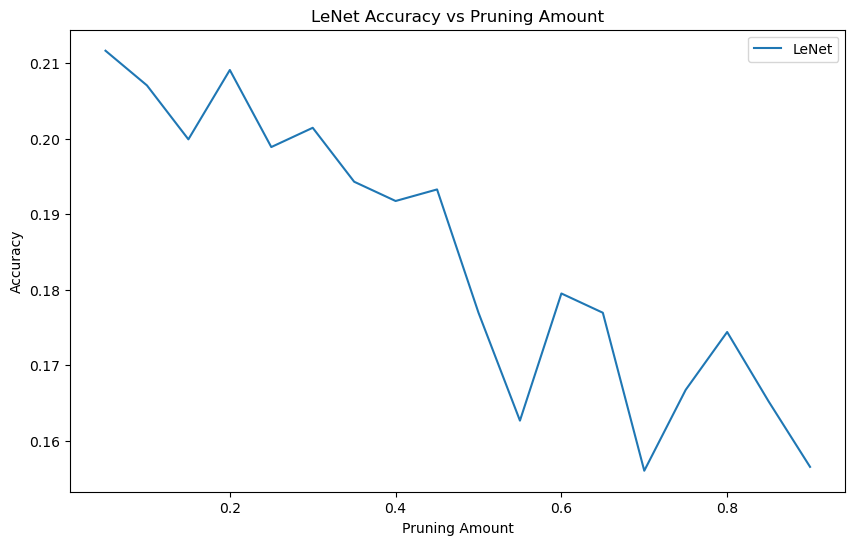

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import numpy as np
import torch.nn.functional as F

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 23)  # Adjust output layer for 23 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Load the LeNet model
lenet = LeNet()
lenet.load_state_dict(torch.load('lenet_model.pth'))
lenet = lenet.to(device)

# Pruning amounts
pruning_amounts = np.arange(0.05, 0.95, 0.05)

# Dictionary to store accuracies
accuracies_lenet = {}

# Apply pruning and evaluate the model
for amount in pruning_amounts:
    pruned_lenet = apply_pruning(lenet, amount=amount)
    accuracy = evaluate_model(pruned_lenet, dataloaders_lenet, dataset_sizes_lenet, device)
    accuracies_lenet[amount] = accuracy
    print(f"Pruning amount: {amount:.2f}, LeNet accuracy: {accuracy:.4f}")

# Plotting the results for LeNet
plt.figure(figsize=(10, 6))
plt.plot(pruning_amounts, list(accuracies_lenet.values()), label='LeNet')
plt.xlabel('Pruning Amount')
plt.ylabel('Accuracy')
plt.title('LeNet Accuracy vs Pruning Amount')
plt.legend()
plt.show()

In [22]:
lenet = LeNet()
lenet.load_state_dict(torch.load('lenet_model.pth'))
pruned_lenet = apply_pruning(lenet, amount=0.35)
torch.save(pruned_lenet.state_dict(), 'pruned_lenet_model.pth')

In [23]:
lenet = LeNet()
lenet.load_state_dict(torch.load('lenet_model.pth'))
lenet = lenet.to(device)
nonzeroparams, memory = estimate_memory_NonzeroParmeter(lenet, device)
print(nonzeroparams, memory)

63111 0.24074935913085938


In [24]:
lenet = LeNet()
lenet.load_state_dict(torch.load('pruned_lenet_model.pth'))
lenet = lenet.to(device)
nonzeroparams, memory = estimate_memory_NonzeroParmeter(lenet, device)
print(nonzeroparams, memory)

41109 0.15944123268127441


## Fine Tuning 

### Training after pruning

In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize the model
model = LeNet().to(device)
model.load_state_dict(torch.load('lenet_model.pth'))
model = apply_pruning(model, amount=0.35)
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Number of epochs for training
num_epochs = 10

# Train the model
model = train_model(model, criterion, optimizer, scheduler, dataloaders_lenet, dataset_sizes_lenet, num_epochs=num_epochs, device=device)
# Save the trained model
torch.save(model.state_dict(), 'trained_pruned_lenet_model.pth')
print("LeNet model saved to 'trained_pruned_lenet_model.pth'")

Epoch 0/9
----------


Epoch 1 train: 100%|██████████| 277/277 [00:40<00:00,  6.78it/s]


train Loss: 2.6399 Acc: 0.2005


Epoch 1 validation: 100%|██████████| 62/62 [00:39<00:00,  1.55it/s]


validation Loss: 2.6128 Acc: 0.2004

Epoch 1/9
----------


Epoch 2 train: 100%|██████████| 277/277 [00:40<00:00,  6.82it/s]


train Loss: 2.6348 Acc: 0.2023


Epoch 2 validation: 100%|██████████| 62/62 [00:38<00:00,  1.62it/s]


validation Loss: 2.6081 Acc: 0.2004

Epoch 2/9
----------


Epoch 3 train: 100%|██████████| 277/277 [00:40<00:00,  6.84it/s]


train Loss: 2.6330 Acc: 0.2019


Epoch 3 validation: 100%|██████████| 62/62 [00:37<00:00,  1.63it/s]


validation Loss: 2.6050 Acc: 0.2024

Epoch 3/9
----------


Epoch 4 train: 100%|██████████| 277/277 [00:40<00:00,  6.88it/s]


train Loss: 2.6301 Acc: 0.2052


Epoch 4 validation: 100%|██████████| 62/62 [00:37<00:00,  1.63it/s]


validation Loss: 2.6024 Acc: 0.2050

Epoch 4/9
----------


Epoch 5 train: 100%|██████████| 277/277 [00:40<00:00,  6.83it/s]


train Loss: 2.6286 Acc: 0.2047


Epoch 5 validation: 100%|██████████| 62/62 [00:38<00:00,  1.62it/s]


validation Loss: 2.6005 Acc: 0.2065

Epoch 5/9
----------


Epoch 6 train: 100%|██████████| 277/277 [00:40<00:00,  6.85it/s]


train Loss: 2.6277 Acc: 0.2049


Epoch 6 validation: 100%|██████████| 62/62 [00:38<00:00,  1.62it/s]


validation Loss: 2.5987 Acc: 0.2096

Epoch 6/9
----------


Epoch 7 train: 100%|██████████| 277/277 [00:40<00:00,  6.81it/s]


train Loss: 2.6259 Acc: 0.2065


Epoch 7 validation: 100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


validation Loss: 2.5971 Acc: 0.2132

Epoch 7/9
----------


Epoch 8 train: 100%|██████████| 277/277 [00:40<00:00,  6.83it/s]


train Loss: 2.6258 Acc: 0.2075


Epoch 8 validation: 100%|██████████| 62/62 [00:37<00:00,  1.64it/s]


validation Loss: 2.5970 Acc: 0.2132

Epoch 8/9
----------


Epoch 9 train: 100%|██████████| 277/277 [00:40<00:00,  6.83it/s]


train Loss: 2.6251 Acc: 0.2060


Epoch 9 validation: 100%|██████████| 62/62 [00:37<00:00,  1.63it/s]


validation Loss: 2.5969 Acc: 0.2132

Epoch 9/9
----------


Epoch 10 train: 100%|██████████| 277/277 [00:40<00:00,  6.77it/s]


train Loss: 2.6259 Acc: 0.2088


Epoch 10 validation: 100%|██████████| 62/62 [00:38<00:00,  1.61it/s]

validation Loss: 2.5968 Acc: 0.2121

Training complete in 13m 9s
Best val Acc: 0.213157
LeNet model saved to 'trained_pruned_lenet_model.pth'


In [28]:
lenet = LeNet()
lenet.load_state_dict(torch.load('trained_pruned_lenet_model.pth'))
lenet = lenet.to(device)
nonzeroparams, memory = estimate_memory_NonzeroParmeter(lenet, device)
print(nonzeroparams, memory)

41109 0.15944123268127441


### AlexNet prunning and evaluation

100%|██████████| 62/62 [00:39<00:00,  1.56it/s]


Pruning amount: 0.05, AlexNet accuracy: 0.8062


100%|██████████| 62/62 [00:43<00:00,  1.43it/s]


Pruning amount: 0.10, AlexNet accuracy: 0.8057


100%|██████████| 62/62 [00:53<00:00,  1.15it/s]


Pruning amount: 0.15, AlexNet accuracy: 0.8093


100%|██████████| 62/62 [00:42<00:00,  1.46it/s]


Pruning amount: 0.20, AlexNet accuracy: 0.8042


100%|██████████| 62/62 [00:39<00:00,  1.57it/s]


Pruning amount: 0.25, AlexNet accuracy: 0.8016


100%|██████████| 62/62 [00:41<00:00,  1.51it/s]


Pruning amount: 0.30, AlexNet accuracy: 0.7981


100%|██████████| 62/62 [00:42<00:00,  1.47it/s]


Pruning amount: 0.35, AlexNet accuracy: 0.7925


100%|██████████| 62/62 [00:41<00:00,  1.49it/s]


Pruning amount: 0.40, AlexNet accuracy: 0.7644


100%|██████████| 62/62 [00:40<00:00,  1.53it/s]


Pruning amount: 0.45, AlexNet accuracy: 0.7328


100%|██████████| 62/62 [00:40<00:00,  1.52it/s]


Pruning amount: 0.50, AlexNet accuracy: 0.6762


100%|██████████| 62/62 [00:38<00:00,  1.59it/s]


Pruning amount: 0.55, AlexNet accuracy: 0.5788


100%|██████████| 62/62 [00:38<00:00,  1.62it/s]


Pruning amount: 0.60, AlexNet accuracy: 0.4462


100%|██████████| 62/62 [00:38<00:00,  1.60it/s]


Pruning amount: 0.65, AlexNet accuracy: 0.3085


100%|██████████| 62/62 [00:38<00:00,  1.60it/s]


Pruning amount: 0.70, AlexNet accuracy: 0.2193


100%|██████████| 62/62 [00:38<00:00,  1.59it/s]


Pruning amount: 0.75, AlexNet accuracy: 0.1346


100%|██████████| 62/62 [00:39<00:00,  1.58it/s]


Pruning amount: 0.80, AlexNet accuracy: 0.1137


100%|██████████| 62/62 [00:39<00:00,  1.59it/s]


Pruning amount: 0.85, AlexNet accuracy: 0.0826


100%|██████████| 62/62 [00:39<00:00,  1.58it/s]

Pruning amount: 0.90, AlexNet accuracy: 0.0627


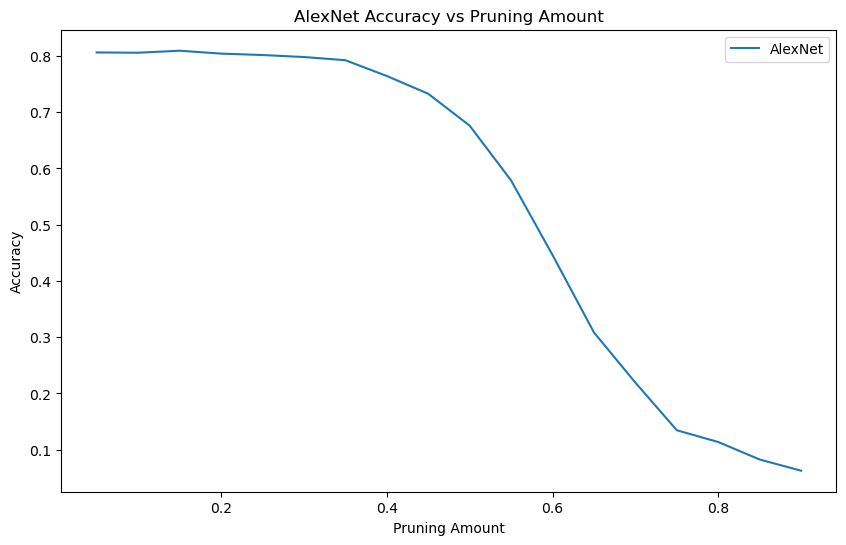

In [20]:
from torchvision import models
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load and prune AlexNet
alexnet = models.alexnet(pretrained=True)
num_ftrs = alexnet.classifier[6].in_features
alexnet.classifier[6] = nn.Linear(num_ftrs, 23)  # Assuming 23 classes
alexnet.load_state_dict(torch.load('alexnet_model.pth'))
alexnet = alexnet.to(device)
# Pruning amounts
pruning_amounts = np.arange(0.05, 0.95, 0.05)

# Dictionary to store accuracies
accuracies_alexnet = {}

# Apply pruning and evaluate the model
for amount in pruning_amounts:
    pruned_alexnet = apply_pruning(alexnet, amount=amount)
    accuracy = evaluate_model(pruned_alexnet, dataloaders_alexnet_vgg16, dataset_sizes_alexnet_vgg16, device)
    accuracies_alexnet[amount] = accuracy
    print(f"Pruning amount: {amount:.2f}, AlexNet accuracy: {accuracy:.4f}")

# Plotting the results for AlexNet
plt.figure(figsize=(10, 6))
plt.plot(pruning_amounts, list(accuracies_alexnet.values()), label='AlexNet')
plt.xlabel('Pruning Amount')
plt.ylabel('Accuracy')
plt.title('AlexNet Accuracy vs Pruning Amount')
plt.legend()
plt.show()

In [33]:
alexnet = models.alexnet(pretrained=True)
num_ftrs = alexnet.classifier[6].in_features
alexnet.classifier[6] = nn.Linear(num_ftrs, 23)  # Assuming 23 classes
alexnet.load_state_dict(torch.load('alexnet_model.pth'))
alexnet = alexnet.to(device)
pruned_alexnet = apply_pruning(alexnet, amount=0.5)
torch.save(pruned_alexnet.state_dict(), 'pruned_alexnet_model.pth')

In [34]:
alexnet = models.alexnet(pretrained=True)
num_ftrs = alexnet.classifier[6].in_features
alexnet.classifier[6] = nn.Linear(num_ftrs, 23)  # Assuming 23 classes
alexnet.load_state_dict(torch.load('alexnet_model.pth'))
alexnet = alexnet.to(device)
nonzeroparams, memory = estimate_memory_NonzeroParmeter(alexnet, device)
print(nonzeroparams, memory)

57098071 217.8118553161621


In [35]:
alexnet = models.alexnet(pretrained=True)
num_ftrs = alexnet.classifier[6].in_features
alexnet.classifier[6] = nn.Linear(num_ftrs, 23)  # Assuming 23 classes
alexnet.load_state_dict(torch.load('pruned_alexnet_model.pth'))
alexnet = alexnet.to(device)
nonzeroparams, memory = estimate_memory_NonzeroParmeter(alexnet, device)
print(nonzeroparams, memory)

28553719 112.32654571533203


### AlexNet Training after prunning

In [36]:
# Setup device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Move model to device
model = models.alexnet(pretrained=True)
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, 23)  # Assuming 23 classes
model.load_state_dict(torch.load('alexnet_model.pth'))
model = model.to(device)
model = apply_pruning(model, amount=0.35)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Number of epochs for training
num_epochs = 10

# Train the model
model = train_model(model, criterion, optimizer, scheduler, dataloaders_alexnet_vgg16, dataset_sizes_alexnet_vgg16, num_epochs=num_epochs, device=device)
# Save the trained model
torch.save(model.state_dict(), 'trained_pruned_alexnet_model.pth')
print("AlexNet model saved to 'trained_pruned_alexnet_model.pth'")

Epoch 0/9
----------


Epoch 1 train: 100%|██████████| 277/277 [00:48<00:00,  5.73it/s]


train Loss: 1.1127 Acc: 0.6481


Epoch 1 validation: 100%|██████████| 62/62 [00:40<00:00,  1.54it/s]


validation Loss: 0.6842 Acc: 0.7940

Epoch 1/9
----------


Epoch 2 train: 100%|██████████| 277/277 [00:47<00:00,  5.77it/s]


train Loss: 1.1074 Acc: 0.6472


Epoch 2 validation: 100%|██████████| 62/62 [00:40<00:00,  1.55it/s]


validation Loss: 0.6782 Acc: 0.7950

Epoch 2/9
----------


Epoch 3 train: 100%|██████████| 277/277 [00:48<00:00,  5.67it/s]


train Loss: 1.0933 Acc: 0.6576


Epoch 3 validation: 100%|██████████| 62/62 [00:40<00:00,  1.52it/s]


validation Loss: 0.6739 Acc: 0.7960

Epoch 3/9
----------


Epoch 4 train: 100%|██████████| 277/277 [00:49<00:00,  5.60it/s]


train Loss: 1.0834 Acc: 0.6559


Epoch 4 validation: 100%|██████████| 62/62 [00:41<00:00,  1.49it/s]


validation Loss: 0.6708 Acc: 0.7976

Epoch 4/9
----------


Epoch 5 train: 100%|██████████| 277/277 [00:49<00:00,  5.61it/s]


train Loss: 1.1137 Acc: 0.6479


Epoch 5 validation: 100%|██████████| 62/62 [00:40<00:00,  1.53it/s]


validation Loss: 0.6701 Acc: 0.7970

Epoch 5/9
----------


Epoch 6 train: 100%|██████████| 277/277 [00:49<00:00,  5.57it/s]


train Loss: 1.0939 Acc: 0.6573


Epoch 6 validation: 100%|██████████| 62/62 [00:40<00:00,  1.53it/s]


validation Loss: 0.6686 Acc: 0.7976

Epoch 6/9
----------


Epoch 7 train: 100%|██████████| 277/277 [00:49<00:00,  5.65it/s]


train Loss: 1.0819 Acc: 0.6545


Epoch 7 validation: 100%|██████████| 62/62 [00:40<00:00,  1.54it/s]


validation Loss: 0.6673 Acc: 0.7970

Epoch 7/9
----------


Epoch 8 train: 100%|██████████| 277/277 [00:48<00:00,  5.76it/s]


train Loss: 1.0878 Acc: 0.6571


Epoch 8 validation: 100%|██████████| 62/62 [00:39<00:00,  1.56it/s]


validation Loss: 0.6671 Acc: 0.7976

Epoch 8/9
----------


Epoch 9 train: 100%|██████████| 277/277 [00:48<00:00,  5.74it/s]


train Loss: 1.0910 Acc: 0.6536


Epoch 9 validation: 100%|██████████| 62/62 [00:40<00:00,  1.54it/s]


validation Loss: 0.6669 Acc: 0.7970

Epoch 9/9
----------


Epoch 10 train: 100%|██████████| 277/277 [00:49<00:00,  5.59it/s]


train Loss: 1.0790 Acc: 0.6600


Epoch 10 validation: 100%|██████████| 62/62 [00:41<00:00,  1.49it/s]


validation Loss: 0.6667 Acc: 0.7970

Training complete in 14m 54s
Best val Acc: 0.797552
AlexNet model saved to 'trained_pruned_alexnet_model.pth'


In [37]:
alexnet = models.alexnet(pretrained=True)
num_ftrs = alexnet.classifier[6].in_features
alexnet.classifier[6] = nn.Linear(num_ftrs, 23)  # Assuming 23 classes
alexnet.load_state_dict(torch.load('trained_pruned_alexnet_model.pth'))
alexnet = alexnet.to(device)
nonzeroparams, memory = estimate_memory_NonzeroParmeter(alexnet, device)
print(nonzeroparams, memory)

37117024 143.97213637828827


### VGG16 prunning and evaluation

100%|██████████| 62/62 [00:56<00:00,  1.09it/s]


Pruning amount: 0.05, VGG16 accuracy: 0.8149


100%|██████████| 62/62 [00:59<00:00,  1.05it/s]


Pruning amount: 0.10, VGG16 accuracy: 0.8164


100%|██████████| 62/62 [00:59<00:00,  1.04it/s]


Pruning amount: 0.15, VGG16 accuracy: 0.8134


100%|██████████| 62/62 [00:59<00:00,  1.05it/s]


Pruning amount: 0.20, VGG16 accuracy: 0.8149


100%|██████████| 62/62 [00:58<00:00,  1.05it/s]


Pruning amount: 0.25, VGG16 accuracy: 0.8108


100%|██████████| 62/62 [00:59<00:00,  1.05it/s]


Pruning amount: 0.30, VGG16 accuracy: 0.8052


100%|██████████| 62/62 [00:59<00:00,  1.04it/s]


Pruning amount: 0.35, VGG16 accuracy: 0.7991


100%|██████████| 62/62 [00:58<00:00,  1.06it/s]


Pruning amount: 0.40, VGG16 accuracy: 0.7970


100%|██████████| 62/62 [00:58<00:00,  1.06it/s]


Pruning amount: 0.45, VGG16 accuracy: 0.7685


100%|██████████| 62/62 [00:59<00:00,  1.04it/s]


Pruning amount: 0.50, VGG16 accuracy: 0.7547


100%|██████████| 62/62 [01:02<00:00,  1.01s/it]


Pruning amount: 0.55, VGG16 accuracy: 0.6849


100%|██████████| 62/62 [00:59<00:00,  1.04it/s]


Pruning amount: 0.60, VGG16 accuracy: 0.6058


100%|██████████| 62/62 [01:01<00:00,  1.00it/s]


Pruning amount: 0.65, VGG16 accuracy: 0.5018


100%|██████████| 62/62 [01:02<00:00,  1.00s/it]


Pruning amount: 0.70, VGG16 accuracy: 0.2580


100%|██████████| 62/62 [01:06<00:00,  1.07s/it]


Pruning amount: 0.75, VGG16 accuracy: 0.1096


100%|██████████| 62/62 [01:03<00:00,  1.02s/it]


Pruning amount: 0.80, VGG16 accuracy: 0.0719


100%|██████████| 62/62 [01:07<00:00,  1.09s/it]


Pruning amount: 0.85, VGG16 accuracy: 0.0581


100%|██████████| 62/62 [01:03<00:00,  1.02s/it]

Pruning amount: 0.90, VGG16 accuracy: 0.0439


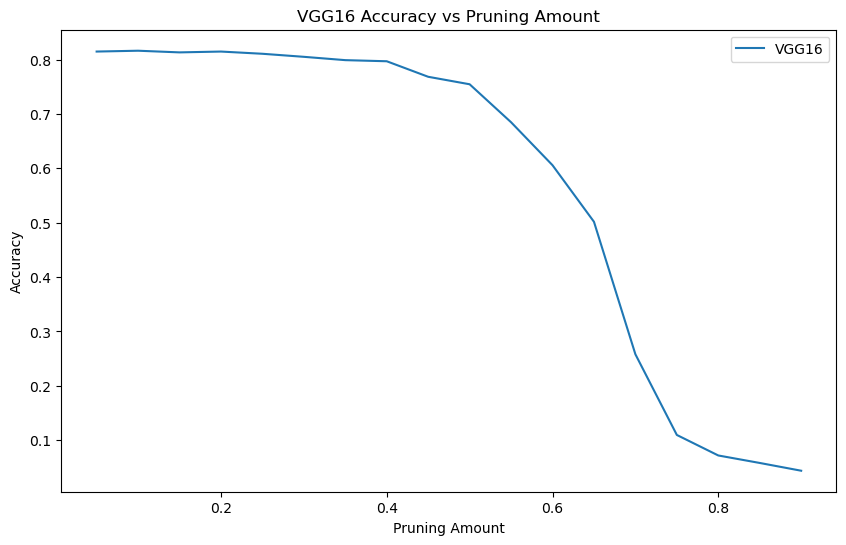

In [38]:
# Load and prune VGG16
vgg16 = models.vgg16(pretrained=True)
num_ftrs = vgg16.classifier[6].in_features
vgg16.classifier[6] = nn.Linear(num_ftrs, 23)  # Assuming 23 classes
vgg16.load_state_dict(torch.load('vgg16_model.pth'))
vgg16 = vgg16.to(device)
# Pruning amounts
pruning_amounts = np.arange(0.05, 0.95, 0.05)

# Dictionary to store accuracies
accuracies_vgg16 = {}

# Apply pruning and evaluate the model
for amount in pruning_amounts:
    pruned_vgg16 = apply_pruning(vgg16, amount=amount)
    accuracy = evaluate_model(pruned_vgg16, dataloaders_alexnet_vgg16, dataset_sizes_alexnet_vgg16, device)
    accuracies_vgg16[amount] = accuracy
    print(f"Pruning amount: {amount:.2f}, VGG16 accuracy: {accuracy:.4f}")

# Plotting the results for VGG16
plt.figure(figsize=(10, 6))
plt.plot(pruning_amounts, list(accuracies_vgg16.values()), label='VGG16')
plt.xlabel('Pruning Amount')
plt.ylabel('Accuracy')
plt.title('VGG16 Accuracy vs Pruning Amount')
plt.legend()
plt.show()

In [39]:
vgg16 = models.vgg16(pretrained=True)
num_ftrs = vgg16.classifier[6].in_features
vgg16.classifier[6] = nn.Linear(num_ftrs, 23)  # Assuming 23 classes
vgg16.load_state_dict(torch.load('vgg16_model.pth'))
vgg16 = vgg16.to(device)
pruned_vgg16 = apply_pruning(vgg16, amount=0.6)
torch.save(pruned_vgg16.state_dict(), 'pruned_vgg16_model.pth')

In [40]:
vgg16 = models.vgg16(pretrained=True)
num_ftrs = vgg16.classifier[6].in_features
vgg16.classifier[6] = nn.Linear(num_ftrs, 23)  # Assuming 23 classes
vgg16.load_state_dict(torch.load('vgg16_model.pth'))
vgg16 = vgg16.to(device)
nonzeroparams, memory = estimate_memory_NonzeroParmeter(vgg16, device)
print(nonzeroparams, memory)

134354775 512.5227928161621


In [41]:
vgg16 = models.vgg16(pretrained=True)
num_ftrs = vgg16.classifier[6].in_features
vgg16.classifier[6] = nn.Linear(num_ftrs, 23)  # Assuming 23 classes
vgg16.load_state_dict(torch.load('pruned_vgg16_model.pth'))
vgg16 = vgg16.to(device)
nonzeroparams, memory = estimate_memory_NonzeroParmeter(vgg16, device)
print(nonzeroparams, memory)

53749371 214.64649152755737


### VGG16 Training after prunning

In [73]:
# Setup device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Move model to device
model = models.vgg16(pretrained=True)
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, 23)  # Assuming 23 classes
model.load_state_dict(torch.load('vgg16_model.pth'))
model = model.to(device)
model = apply_pruning(model, amount=0.4)
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Number of epochs for training
num_epochs = 1

# Train the model
model = train_model(model, criterion, optimizer, scheduler, dataloaders_alexnet_vgg16, dataset_sizes_alexnet_vgg16, num_epochs=num_epochs, device=device)
# Save the trained model
torch.save(model.state_dict(), 'trained_pruned_vgg16_model.pth')
print("VGG16 model saved to 'trained_pruned_vgg16_model.pth'")

Epoch 0/0
----------


Epoch 1 train: 100%|██████████| 277/277 [11:26<00:00,  2.48s/it]


train Loss: 1.0545 Acc: 0.6774


Epoch 1 validation: 100%|██████████| 62/62 [01:28<00:00,  1.43s/it]


validation Loss: 0.6237 Acc: 0.8098

Training complete in 12m 55s
Best val Acc: 0.809791
VGG16 model saved to 'trained_pruned_vgg16_model.pth'


In [ ]:
vgg16 = models.vgg16(pretrained=True)
num_ftrs = vgg16.classifier[6].in_features
vgg16.classifier[6] = nn.Linear(num_ftrs, 23)  # Assuming 23 classes
vgg16.load_state_dict(torch.load('trained_pruned_vgg16_model.pth'))
vgg16 = vgg16.to(device)
nonzeroparams, memory = estimate_memory_NonzeroParmeter(vgg16, device)
print(nonzeroparams, memory)

# Quantization

### Quantization function

In [37]:
# Setup device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import torch
import torch.nn as nn
from torchvision import models

# Function to apply quantization
def apply_quantization(model, config):
    model.qconfig = config
    torch.quantization.prepare(model, inplace=False)
    torch.quantization.convert(model, inplace=False)
    return model

# Custom quantization configuration
custom_qconfig = torch.quantization.QConfig(
    activation=torch.quantization.MinMaxObserver.with_args(dtype=torch.qint8),
    weight=torch.quantization.default_weight_observer
)


### LeNet quantization

In [38]:
# LeNet class is already defined
# Load the original LeNet model

lenet = LeNet()
lenet.load_state_dict(torch.load('lenet_model.pth'))
lenet = lenet.to(device)
lenet.eval()

# Apply quantization to LeNet
lenet_quantized = apply_quantization(lenet, custom_qconfig)
torch.save(lenet_quantized.state_dict(), 'quantized_lenet_model.pth')
print("LeNet quantized and saved.")


LeNet quantized and saved.


In [7]:
lenet_quantized.eval()
lenet_accuracy = evaluate_model(lenet_quantized, dataloaders_lenet, dataset_sizes_lenet, device)
print(f"Quantized LeNet accuracy: {lenet_accuracy:.4f}")

100%|██████████| 62/62 [00:42<00:00,  1.46it/s]
Quantized LeNet accuracy: 0.1038


### AlexNet quantization

In [28]:
# Load the original AlexNet model
alexnet = models.alexnet(pretrained=True)
alexnet.classifier[6] = nn.Linear(alexnet.classifier[6].in_features, 23)
alexnet.load_state_dict(torch.load('alexnet_model.pth'))
alexnet = alexnet.to(device)
alexnet.eval()

# Apply quantization to AlexNet
alexnet_quantized = apply_quantization(alexnet, custom_qconfig)
torch.save(alexnet_quantized.state_dict(), 'quantized_alexnet_model.pth')
print("AlexNet quantized and saved.")

C:\Users\rk4585\AppData\Local\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet quantized and saved.


In [8]:
alexnet_quantized.eval()
alexnet_accuracy = evaluate_model(alexnet_quantized, dataloaders_alexnet_vgg16, dataset_sizes_alexnet_vgg16, device)
print(f"Quantized AlexNet accuracy: {alexnet_accuracy:.4f}")

100%|██████████| 62/62 [00:44<00:00,  1.41it/s]
Quantized AlexNet accuracy: 0.724


### VGG16 quantization

In [71]:
# Load the original VGG16 model
vgg16 = models.vgg16(pretrained=True)
vgg16.classifier[6] = nn.Linear(vgg16.classifier[6].in_features, 23)
vgg16.load_state_dict(torch.load('vgg16_model.pth'))
vgg16 = vgg16.to(device)
vgg16.eval()

# Apply quantization to VGG16
vgg16_quantized = apply_quantization(vgg16, custom_qconfig)
torch.save(vgg16_quantized.state_dict(), 'quantized_vgg16_model.pth')
print("VGG16 quantized and saved.")

VGG16 quantized and saved.


In [9]:
vgg16_quantized.eval()
vgg16_accuracy = evaluate_model(vgg16_quantized, dataloaders_alexnet_vgg16, dataset_sizes_alexnet_vgg16, device)
print(f"Quantized VGG16 accuracy: {vgg16_accuracy:.4f}")


100%|██████████| 62/62 [00:56<00:00,  1.10it/s]
Quantized VGG16 accuracy: 0.793


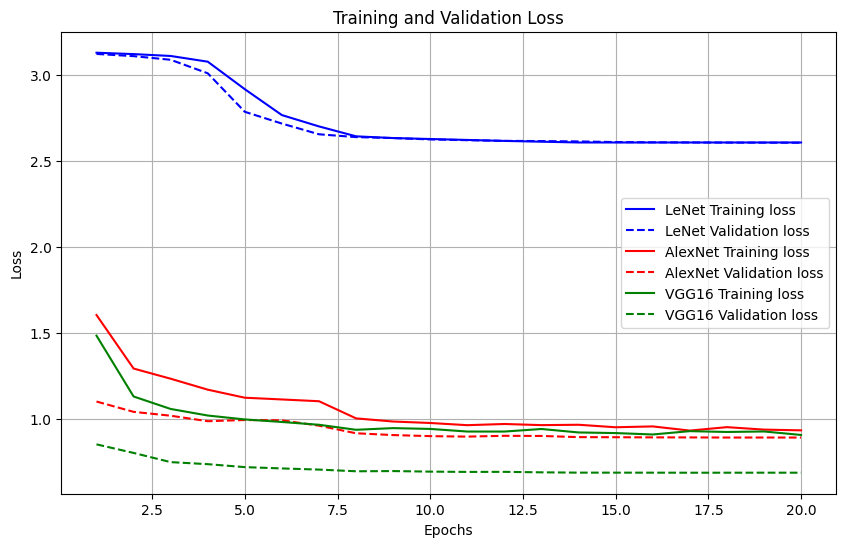

In [1]:
import matplotlib.pyplot as plt

def plot_training_curves(LeNet_train_loss, LeNet_val_loss, AlexNet_train_loss, AlexNet_val_loss, VGG16_train_loss, VGG16_val_loss):
    epochs = range(1, len(LeNet_train_loss) + 1)
    
    plt.figure(figsize=(10, 6))
    
    # Plot LeNet training and validation loss
    plt.plot(epochs, LeNet_train_loss, 'b', label='LeNet Training loss')
    plt.plot(epochs, LeNet_val_loss, 'b--', label='LeNet Validation loss')
    
    # Plot AlexNet training and validation loss
    plt.plot(epochs, AlexNet_train_loss, 'r', label='AlexNet Training loss')
    plt.plot(epochs, AlexNet_val_loss, 'r--', label='AlexNet Validation loss')
    
    # Plot VGG16 training and validation loss
    plt.plot(epochs, VGG16_train_loss, 'g', label='VGG16 Training loss')
    plt.plot(epochs, VGG16_val_loss, 'g--', label='VGG16 Validation loss')
    
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
LeNet_train_loss = [3.1308, 3.1228, 3.1119, 3.0787, 2.9187, 2.7682, 2.7024, 2.6448, 2.6347, 2.6292, 2.6238, 2.6181, 2.6136, 2.6090, 2.6090, 2.6090, 2.6090, 2.6090, 2.6090, 2.6090]
LeNet_val_loss = [3.1237, 3.1109, 3.0897, 3.0112, 2.7873, 2.7189, 2.6567, 2.6403, 2.6347, 2.6268, 2.6223, 2.6184, 2.6172, 2.6151, 2.6115, 2.6099, 2.6091, 2.6083, 2.6080, 2.6075]

AlexNet_train_loss = [1.6060, 1.2949, 1.2357, 1.1721, 1.1253, 1.1152, 1.1049, 1.0052, 0.9869, 0.9784, 0.9657, 0.9726, 0.9660, 0.9681, 0.9536, 0.9585, 0.9342, 0.9542, 0.9399, 0.9356]
AlexNet_val_loss = [1.1032, 1.0432, 1.0207, 0.9888, 0.9957, 0.9940, 0.9628, 0.9186, 0.9082, 0.9020, 0.8992, 0.9039, 0.9030, 0.8962, 0.8956, 0.8948, 0.8945, 0.8938, 0.8939, 0.8937]

VGG16_train_loss = [1.4860, 1.1325, 1.0599, 1.0218, 0.9990, 0.9843, 0.9680, 0.9389, 0.9486, 0.9439, 0.9287, 0.9286, 0.9435, 0.9234, 0.9198, 0.9116, 0.9310, 0.9262, 0.9291, 0.9089]
VGG16_val_loss = [0.8542, 0.8044, 0.7509, 0.7390, 0.7219, 0.7142, 0.7075, 0.6977, 0.6989, 0.6957, 0.6940, 0.6944, 0.6916, 0.6898, 0.6897, 0.6896, 0.6893, 0.6894, 0.6895, 0.6894]

plot_training_curves(LeNet_train_loss, LeNet_val_loss, AlexNet_train_loss, AlexNet_val_loss, VGG16_train_loss, VGG16_val_loss)
